<style>
    h2 {
    background-color: #ffebcd;
    padding: 9px;
    border: 2px solid #deb887;
    }
</style>
# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

## CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

---
## Business Understanding
From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

---
### Data Mining Goals and KPIs ("_The Data Problem Definition_")

Utilize statistical approaches to sanitize and/or impute any feature (independent variable) values within the dataset to understand correlations and collinearity of used car features to independently predict the target feature, sale price. From this understanding, only retain features that demonstrate reasonable correlations, and engineer any relevant features that may enrich the dataset when modeling.  

From this new prepared dataset, train a few regression model estimators to determine which may most reasonably predict out-of-sample sale prices based on known key car features. Each model's hyperparameters will be optimized for it's best performance, where the model with the lowest prediction error will be considered the best estimator.

The best estimator's coefficients/algorithm will eventually become a testing tool provided to our client (_Fast Ameet's Used Car Emporium_) to guide future used car inventory to optimize minimize the time a car sits in their car lot (ROI).

---

## Notebook Setup
* Imported Python libraries and methods
* General configurations
* Load the *vehicles* dataset
* Custom functions

### Python Libraries and Methods

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance

import warnings


### Environment Configurations

In [2]:
# Default plot figure sizes
plt.rcParams["figure.figsize"] = (16, 5)
plt.rc('font', size=14)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=14)

# Pipeline configuration visualization
from sklearn import set_config
set_config(display="diagram")

# Silence any warnings
#warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.4f' % x)


### Load the Dataset

In [3]:
df = pd.read_csv("data/vehicles.csv")

# retain a copy of the original dataset
original_df = df.copy()
original_shape = original_df.shape

df.shape, original_shape

((426880, 18), (426880, 18))

### Custom Python Functions

#### helper_print_heading()

In [4]:
def helper_print_heading ( heading, length = 120 ):
    '''
    Purpose: Uniform means to add a heading to printed information
    Inputs:
    - heading: string to use for heading, uppercased by default
    - length: override overall width consumed by title and dashes
    '''
    padding = int(( length - len(heading) - 6 ) / 2 )
    return '\n/' + ('─' * padding) + f'  {heading.upper()}  ' + ('─' * padding) + "/\n"


#### check_sequence()

In [5]:
def check_sequence( test_number ):
    '''
    Purpose: Identify "unrealistic" car prices to exclude from the modeling
    Function: Evalute a number's value, hypothesizing it's "unrealistic" if it's:
    - below a threshold (100)
    - digits in sequence (ascending or descending order)
    - single digit repeating
    - above a threshold (> 5MM)
            
    Inputs:
    - test_number: number who's value will be tested for the above stated conditions:
    '''
    
    # Initialize return variable, start by presuming the number if "good"
    is_fake = False
    
    lower_bound = 500
    #upper_bound = 5000000
    upper_bound = 100000
    
    test_number_str = str( test_number )
    first_digit = int ( test_number_str[0] )
    last_digit = int ( test_number_str[-1] )
    
    # Check if the value is below threshold
    if int( test_number ) < lower_bound:
        #is_fake = True
        return "low"
        
    # Check if the value is a sequence
    if test_number_str == ''.join( str( i ) for i in range( first_digit, last_digit + 1 )):
        #is_fake = True
        return "sequence (asc)"
    
    if test_number_str == ''.join( str( i ) for i in range( first_digit, last_digit - 1, -1 )):
        #is_fake = True
        return "sequence (desc)"

    # Check if the value is repeating
    if len( set( test_number_str )) == 1:
        #is_fake = True
        return "repeating"
    
    # Check if the value is above the `upper_bound`
    if int( test_number_str ) > upper_bound:
        #is_fake = True
        return "high"
    
    #return is_fake
    return "valid"


#### age_category()

In [6]:
def age_category( manufacture_year ):
    '''
    Purpose: Based on the `manufacture_year` of the car, return category it falls within
    Function: Compare `manufacture_year` between spans to determine which category it fits into:
    - "vintage": manufactured between 1919-1930
    - "antique": manufactured before 1979, or >45 years old
    - "classic": manufactured before 2004, or >20 years old
    - "contemporary": manufactured after 2003, or <=20 years old (aka "modern")
            
    Inputs:
    - manufacture_year: when the car was manufactured

    Reference: https://americancollectors.com/articles/vintage-vs-classic-vs-antique-cars/
    '''
    # Current Year 
    current_year = datetime.now().year
    age = current_year - manufacture_year
    
    if manufacture_year <= 1930:
        car_category = "vintage"
    elif age > 45:
        car_category = "antique"
    elif age > 20:
        car_category = "classic"
    else:
        car_category = "contemporary"

    return car_category


#### review_missing_data()

In [7]:
def review_missing_data( dataframe ):
    '''
    Purpose: Review missing values and duplicated records for the `dataframe` provided
    Function: 
        - tabular view to understand missing data by feature
        - bar chart view to visualize percentage missing values by feature
        - heatmap view to understand distribution of missing data
            
    Inputs:
    - manufacture_year: when the car was manufactured

    
    '''
    
    df_missing_sum = dataframe.isna().sum()
    df_missing_perc = round(dataframe.isna().mean()*100, 3)
    df_integrity = pd.DataFrame( { "Missing Values": df_missing_sum, 
                                  "Percentage": df_missing_perc }
                               ).sort_values("Percentage", ascending=False)
    
    print( helper_print_heading( 'Total Missing Values by Feature' ))
    display( df_integrity )
    print( helper_print_heading( 'Number of Duplicated Records in Dataset' ), f"{dataframe.duplicated().sum()} records duplicated" )
    
    df_integrity["Percentage"].plot(kind="bar", title="Percentage Data Missing by Feature")
    plt.ylabel("Percent (%)")
    plt.xlabel("Data Features Within Dataset")
    plt.show()
    
    # Let's visually evaluate the missing data across any data feature to understand distribution, 
    # for any additional insights
    sns.heatmap(dataframe.isna()).set_title("Heatmap Visualizing the Spread of Missing Data")
    plt.xlabel("Data Features")
    plt.ylabel("Observation Number")
    plt.show()
    

#### sanitize_coef_labels()

In [8]:
def sanitize_coef_labels( label ):
    '''
    Purpose: Features transformed as part of a pipeline will have the pipeline element's label 
                prepended to indicate which transformer was responsible for creating it. This 
                function strips the prefixes and makes the label more digestible.
    Function: 
        - Removes "ohe__" prefix
        - Removes "poly__" prefix
            
    Inputs:
    - label: current feature label name for the coefficient

    Returns:
    - updated label name
    '''
    return label.replace( "ohe__", "" ) \
                .replace( "poly__", "" ) \
                .replace( " ", " * " ) \
                .strip()

In [9]:
print( helper_print_heading( "Environment and Dataset Loaded!" ))


/─────────────────────────────────────────  ENVIRONMENT AND DATASET LOADED!  ─────────────────────────────────────────/



## Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

---

### Exploring the Dataset (EDA)
* Review data integrity (missing values or duplicated records) to inform decisions to either impute or drop null data values from the dataset.
* Understand each feature's value sets and data type to determine if any type changes or feature engineering will be beneficial. (univariate analysis)
* Generate a correlation matrix to understand if any features demonstrate multicollinearity and should be omitted from the prepared dataset to model against. (bivariate analysis)
* Generate plots as relevant to understand how different feature values may impact sale pricing.

---

### Data Integrity Review

In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [11]:
df.describe([.1, .2, .85, .95, .99], include='all') 
# data will need to be scaled/normalized

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
count,426880.0000,426880,426880.0000,425675.0000,409234,421603,252776,249202,423867,422480.0000,418638,424324,265838,296313,120519,334022,296677,426880
unique,NaN,404,NaN,NaN,42,29649,6,8,5,NaN,6,3,118246,3,4,13,12,51
top,NaN,columbus,NaN,NaN,ford,f-150,good,6 cylinders,gas,NaN,clean,automatic,1FMJU1JT1HEA52352,4wd,full-size,sedan,white,ca
freq,NaN,3608,NaN,NaN,70985,8009,121456,94169,356209,NaN,405117,336524,261,131904,63465,87056,79285,50614
mean,7311486634.2243,NaN,75199.0332,2011.2352,NaN,NaN,NaN,NaN,NaN,98043.3314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4473170.4126,NaN,12182282.1736,9.4521,NaN,NaN,NaN,NaN,NaN,213881.5008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,7207408119.0000,NaN,0.0000,1900.0000,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10%,7304399132.1000,NaN,500.0000,2003.0000,NaN,NaN,NaN,NaN,NaN,14939.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20%,7307115339.2000,NaN,4500.0000,2007.0000,NaN,NaN,NaN,NaN,NaN,30000.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,7312620821.0000,NaN,13950.0000,2013.0000,NaN,NaN,NaN,NaN,NaN,85548.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Overall percentage missing data for entire dataset
(df.isna().mean() * 100).mean()

15.81438447442945


/─────────────────────────────────────────  TOTAL MISSING VALUES BY FEATURE  ─────────────────────────────────────────/



,Missing Values,Percentage
size,306361,71.7670
cylinders,177678,41.6220
condition,174104,40.7850
VIN,161042,37.7250
drive,130567,30.5860
paint_color,130203,30.5010
type,92858,21.7530
manufacturer,17646,4.1340
title_status,8242,1.9310
model,5277,1.2360



/─────────────────────────────────────  NUMBER OF DUPLICATED RECORDS IN DATASET  ─────────────────────────────────────/
 0 records duplicated


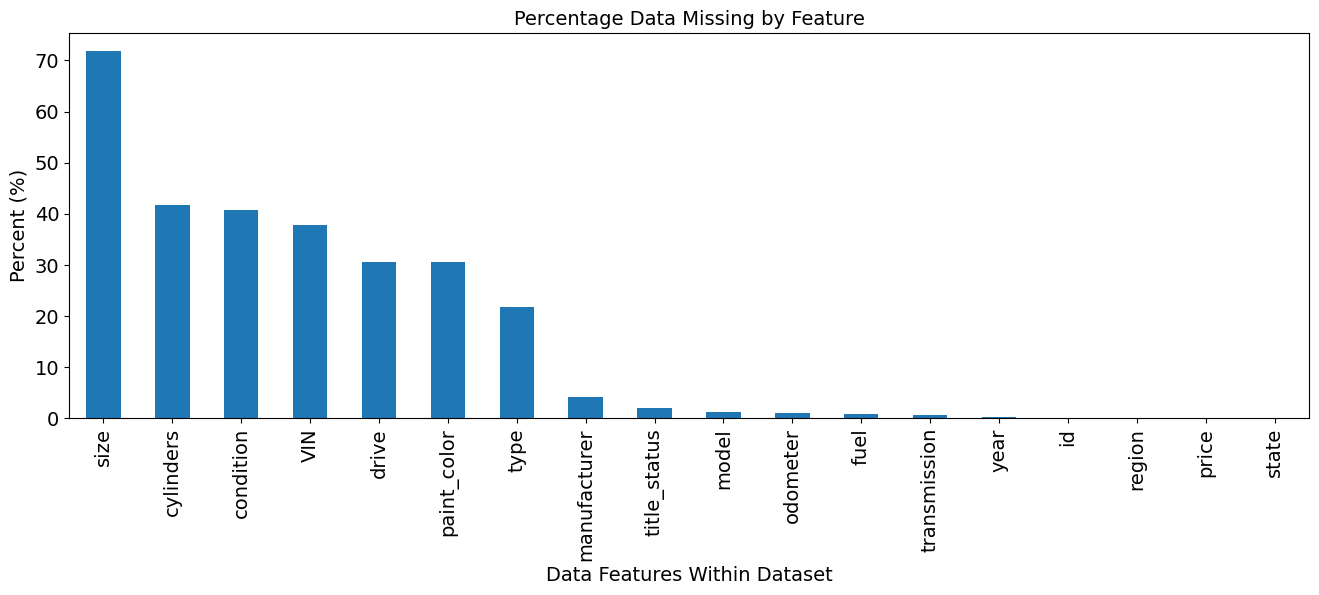

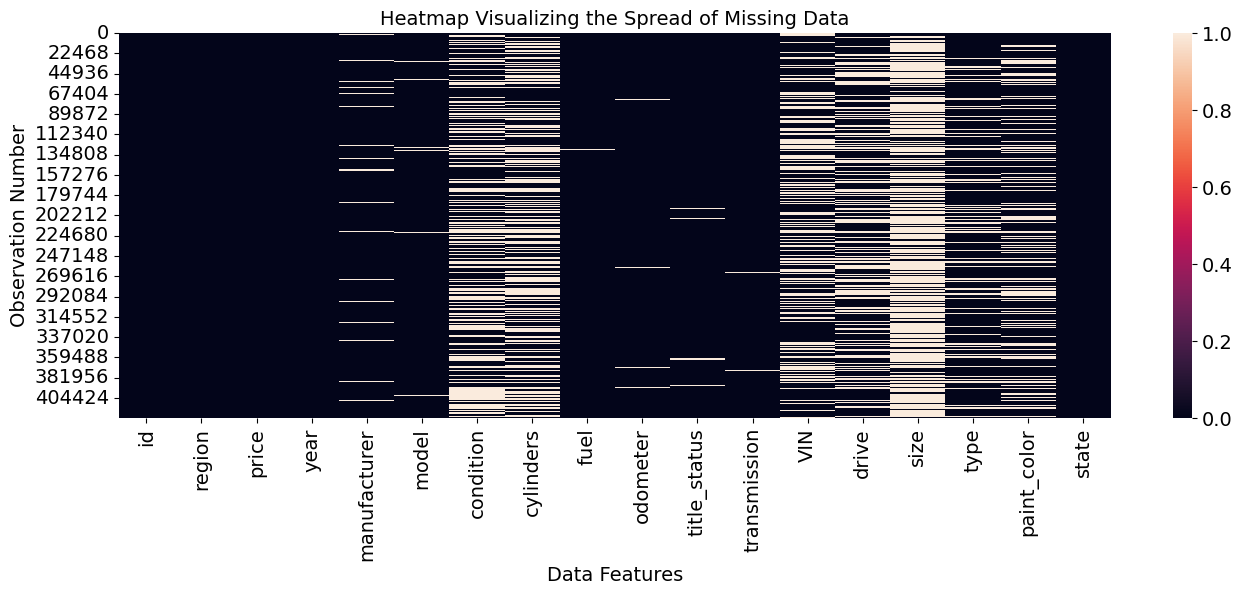

In [13]:
'''
Review missing values and duplicated records:
- tabular view to understand missing data by feature
- heatmap view to understand distribution of missing data
'''

review_missing_data( df )

---
#### Observations:
* Quite a lot of missing values within this dataset.
* A review of individual features and their potential modeling value is needed before addressing missing values.
* Selected numerical features will require standardization/scaling before modeling.
---

### Review Each Feature for Potential Usefulness

Take a cursory review of each feature's data type and values to understand which may be important, and which can be dropped.

In [14]:
'''
Establish lists for categorical and numberical features for future transformations
- Drop the noisy/largely unique features so plots are useful
'''
cols_df = df.drop(["id", "VIN", "region", "model"], axis=1)
cols_categorical = cols_df.select_dtypes(include=["object"]).columns.tolist()
cols_numerical = cols_df.select_dtypes(exclude=["object"]).columns.tolist()
cols_categorical, cols_numerical

(['manufacturer',
  'condition',
  'cylinders',
  'fuel',
  'title_status',
  'transmission',
  'drive',
  'size',
  'type',
  'paint_color',
  'state'],
 ['price', 'year', 'odometer'])

In [15]:
df["model"].value_counts(normalize=True) * 100
# too many unique values; may consider a laborious sanitization to make the values more uniform and potentially useful, 
# but let's drop the feature for current modeling exercise.

model
f-150                     1.8997
silverado 1500            1.2192
1500                      0.9988
camry                     0.7436
silverado                 0.7170
                           ...  
plymouth fury 1           0.0002
f550 box truck delivery   0.0002
duramax 2500hd            0.0002
3 s sport                 0.0002
Paige Glenbrook Touring   0.0002
Name: proportion, Length: 29649, dtype: float64

In [16]:
df["year"].value_counts(normalize=True) * 100
# Use `year` to categorize cars (later step)

year
2017.0000   8.5558
2018.0000   8.5438
2015.0000   7.4089
2013.0000   7.2342
2016.0000   7.1496
             ...  
1943.0000   0.0002
1915.0000   0.0002
1902.0000   0.0002
1905.0000   0.0002
1909.0000   0.0002
Name: proportion, Length: 114, dtype: float64

#### Explore "id" Feature

In [17]:
display(pd.DataFrame(df["id"].value_counts( dropna=False ).sort_values( ascending=False ).head()))
# There may be some value in computing distance between IDs in some grouped datasets, but for now, dropping this feature.

,count
id,
7222695916,1
7314589649,1
7222270760,1
7210384030,1
7222379453,1


#### Explore "VIN" Feature

In [18]:
df["VIN"].value_counts( dropna=False, normalize=True ).sort_values( ascending=False ).head()


VIN
NaN                 0.3773
1FMJU1JT1HEA52352   0.0006
3C6JR6DT3KG560649   0.0006
1FTER1EH1LLA36301   0.0005
5TFTX4CN3EX042751   0.0005
Name: proportion, dtype: float64

**Investigate:** `VIN` column should represent a unique Vehicle ID, explore one vehicle ID to see if it's multple sales of the same vehicle, or just listed multiple locations for sale

In [19]:
df.query("VIN == '3C6JR6DT3KG560649'").sample(10)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
385731,7314829480,ogden-clearfield,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,ut
284549,7313481982,new hampshire,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,nh
183997,7311822796,cumberland valley,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,md
302888,7313268484,tuscarawas co,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,oh
304056,7311843054,lawton,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,ok
151865,7313407478,indianapolis,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,in
423448,7313251637,milwaukee,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,wi
338549,7311872097,poconos,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,pa
175498,7313237218,lafayette,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,la
64678,7313248511,stockton,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,ca


In [20]:
df["VIN"].value_counts( dropna=False).sort_values( ascending=False ).head(25)

VIN
NaN                  161042
1FMJU1JT1HEA52352       261
3C6JR6DT3KG560649       235
1FTER1EH1LLA36301       231
5TFTX4CN3EX042751       227
1GCHTCE37G1186784       214
1GTN1TEH5EZ273019       207
3VWF17AT1FM655022       199
JN1AZ4EH8KM420880       198
1FTMF1CP3GKD62143       195
1GTR1WE07DZ143724       194
1GT22REG1GZ401351       180
1G1FF1R79G0140582       172
WMEEJ3BA2DK636540       168
1GCVKREH6GZ228691       167
2GTV2LECXK1123316       160
JA4AP3AU9LU013694       157
WDDTG5CB9FJ051220       156
1GT220CG8CZ231238       151
3TMLU4EN4CM085701       150
JM1NDAC74L0413665       150
1GCNCNEH7HZ118773       149
WBAUP9C53CVL91190       145
5TFUM5F13GX069124       145
JTNKARJE9GJ510268       143
Name: count, dtype: int64

In [21]:
'''
Based on sorting records for a single VIN (car) available in multiple regions for sale, 
the car was listed in the dataset in alphabetical order by state, region.
But the `id` field seems like it was the order it was listed in the system of record, 
perhaps indicating the earliest `id` is the first time the car's VIN was listed.
(there is no datestamps to confer)
''' 
print('Single VIN sorted by dataframe index:')
display(df.query("VIN == '3C6JR6DT3KG560649'").sort_index())

print('Single VIN sorted by `id` column:')
display(df.query("VIN == '3C6JR6DT3KG560649'").sort_values('id'))

Single VIN sorted by dataframe index:


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
62,7313337060,auburn,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,al
572,7313375333,birmingham,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,al
1905,7313325127,dothan,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,al
2184,7313336901,florence / muscle shoals,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,al
2361,7313325231,gadsden-anniston,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420450,7313349205,madison,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,wi
423448,7313251637,milwaukee,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,wi
425339,7313343381,sheboygan,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,wi
425839,7311961016,wausau,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,wi


Single VIN sorted by `id` column:


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
340615,7311767769,williamsport,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,pa
36198,7311767815,merced,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,ca
177424,7311767818,shreveport,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,la
91360,7311768633,delaware,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,de
188684,7311768653,cape cod / islands,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,ma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3901,7314652214,mobile,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,al
313985,7314677559,corvallis/albany,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,or
107541,7314687308,pensacola,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,fl
385813,7314817727,provo / orem,25990,2019.0000,ram,1500 classic regular cab,good,8 cylinders,gas,12302.0000,clean,other,3C6JR6DT3KG560649,NaN,NaN,pickup,white,ut


In [22]:
df.query("VIN == '3C6JR6DT3KG560649'").duplicated().sum()

0

In [23]:
df.drop(["region", "state"], axis=1).query("VIN == '3C6JR6DT3KG560649'").duplicated().sum()

0

***Insight:*** Seek to keep only first instance of a unique VIN value, dropping any other occurrences.

In [24]:
df["size"].value_counts( dropna=False, normalize=True ).sort_values( ascending=False )

size
NaN           0.7177
full-size     0.1487
mid-size      0.0808
compact       0.0454
sub-compact   0.0075
Name: proportion, dtype: float64

#### Univariate Analysis
Explore each categorical and numerical feature to understand each feature's values, and potential options to address missing values

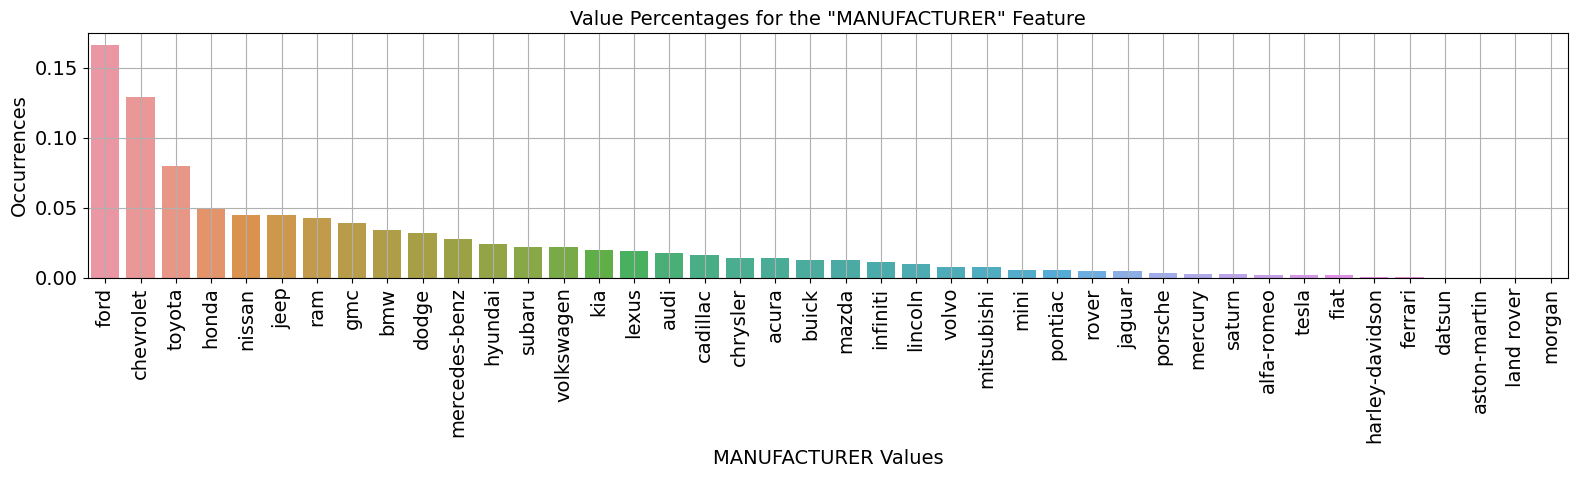

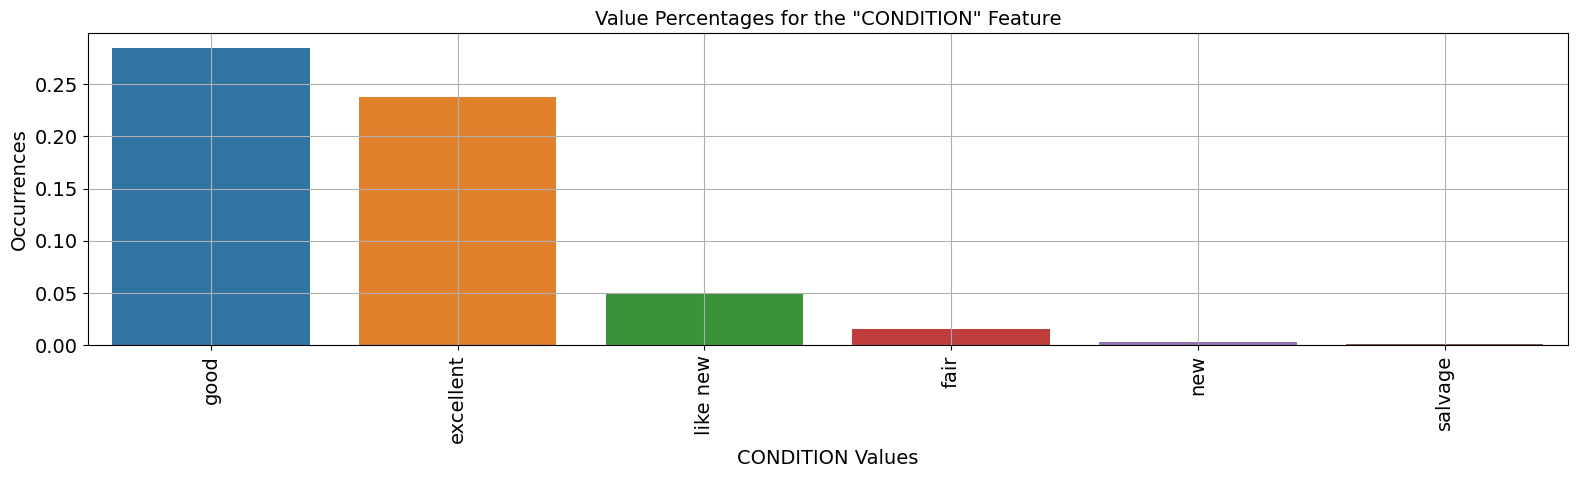

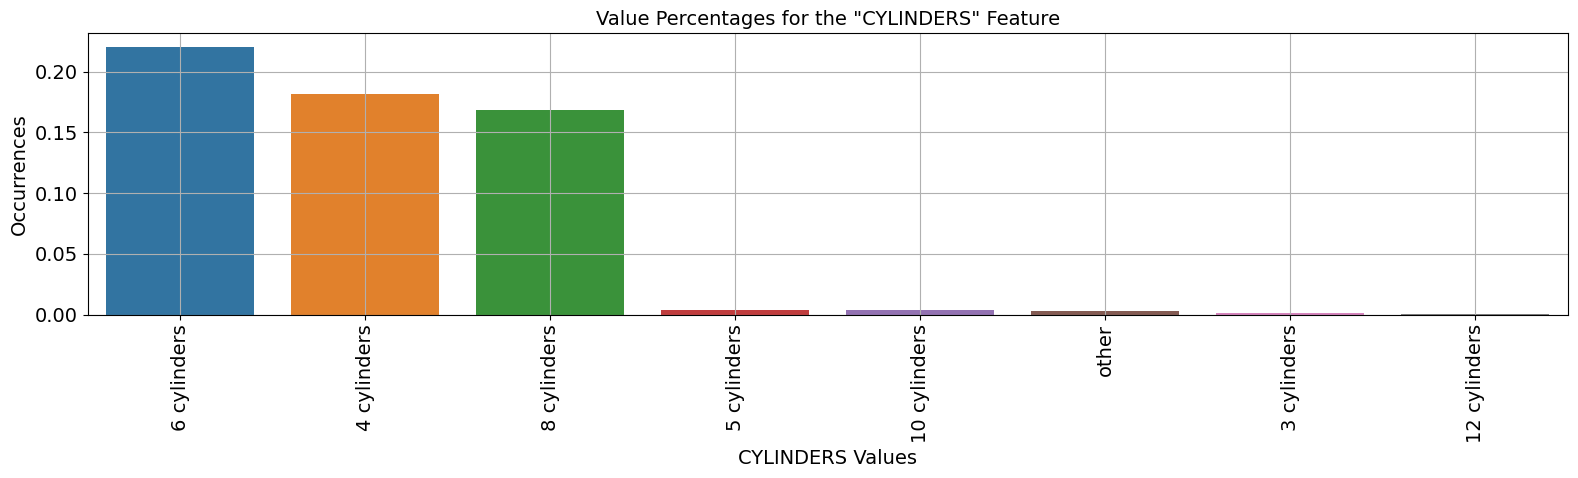

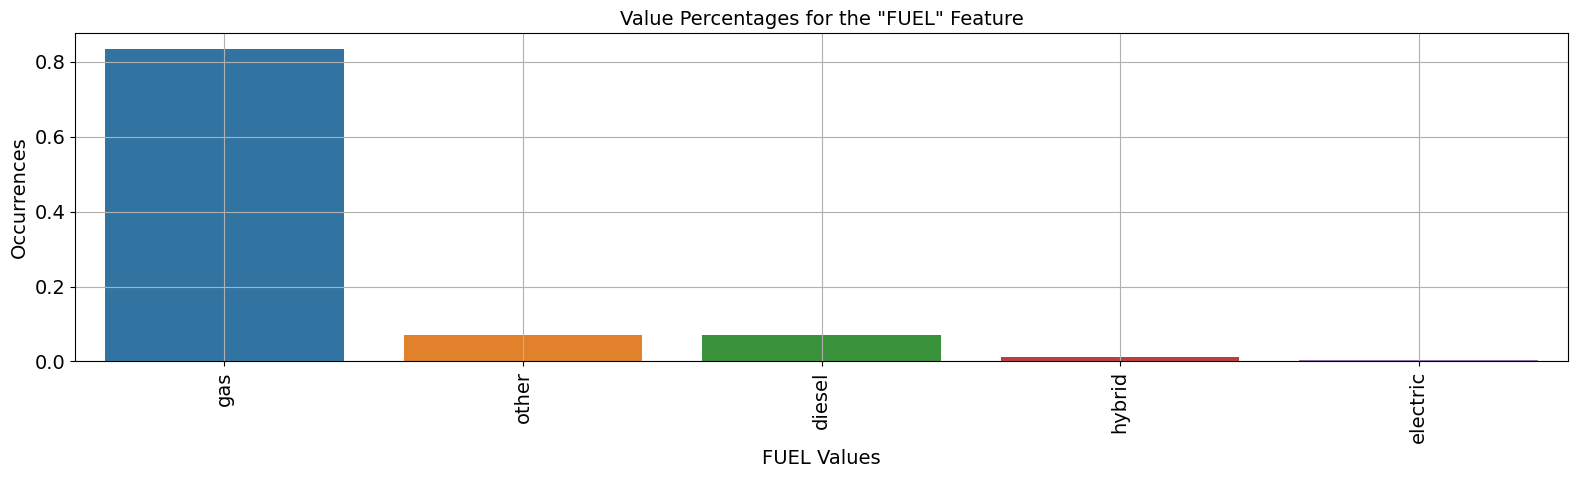

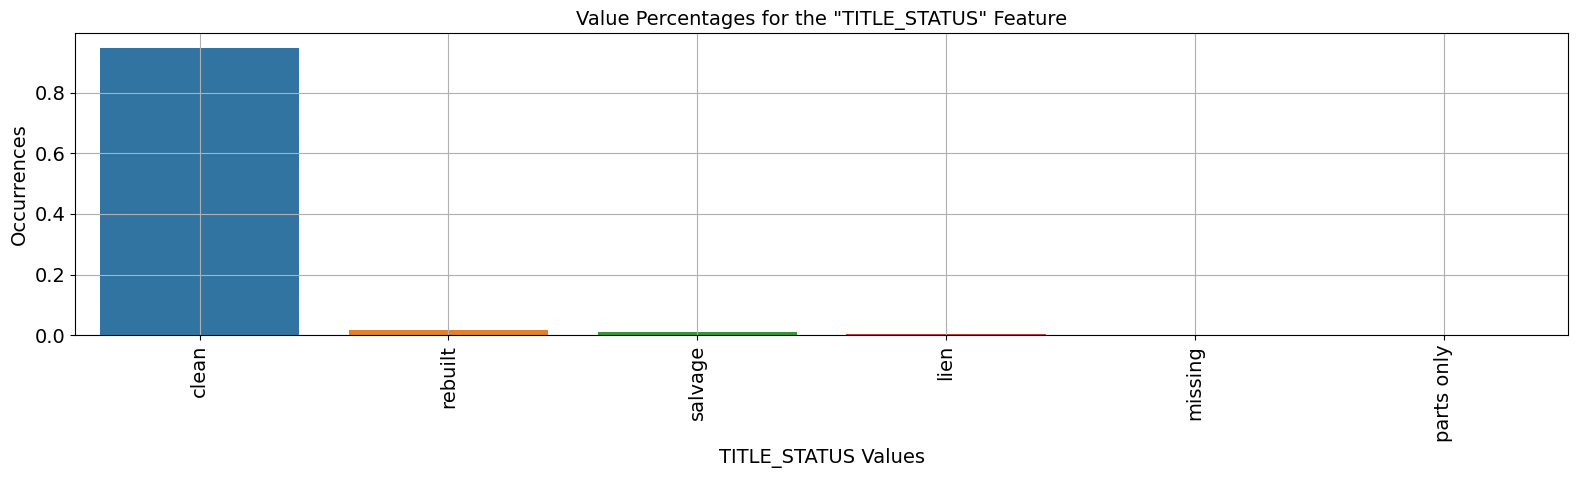

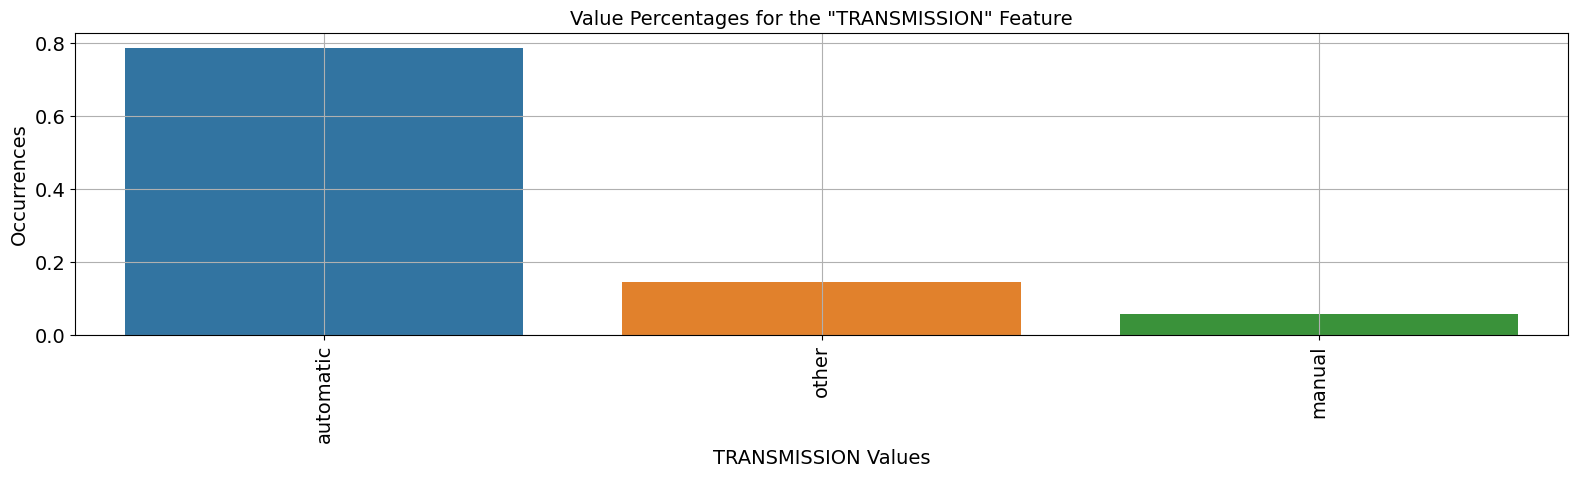

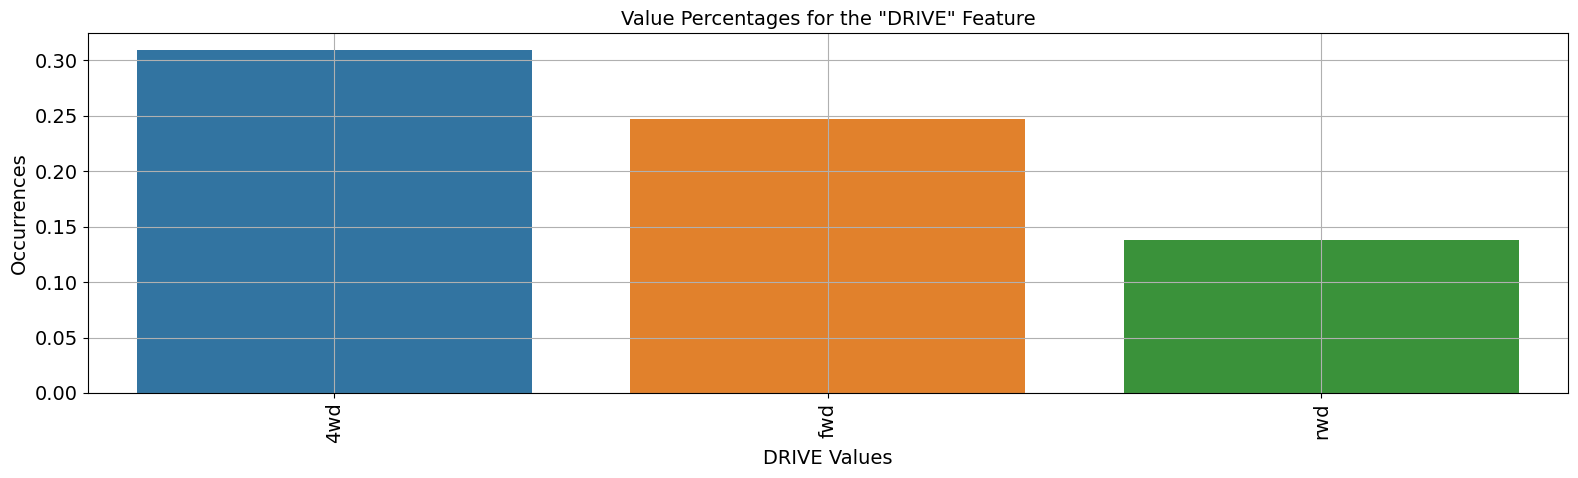

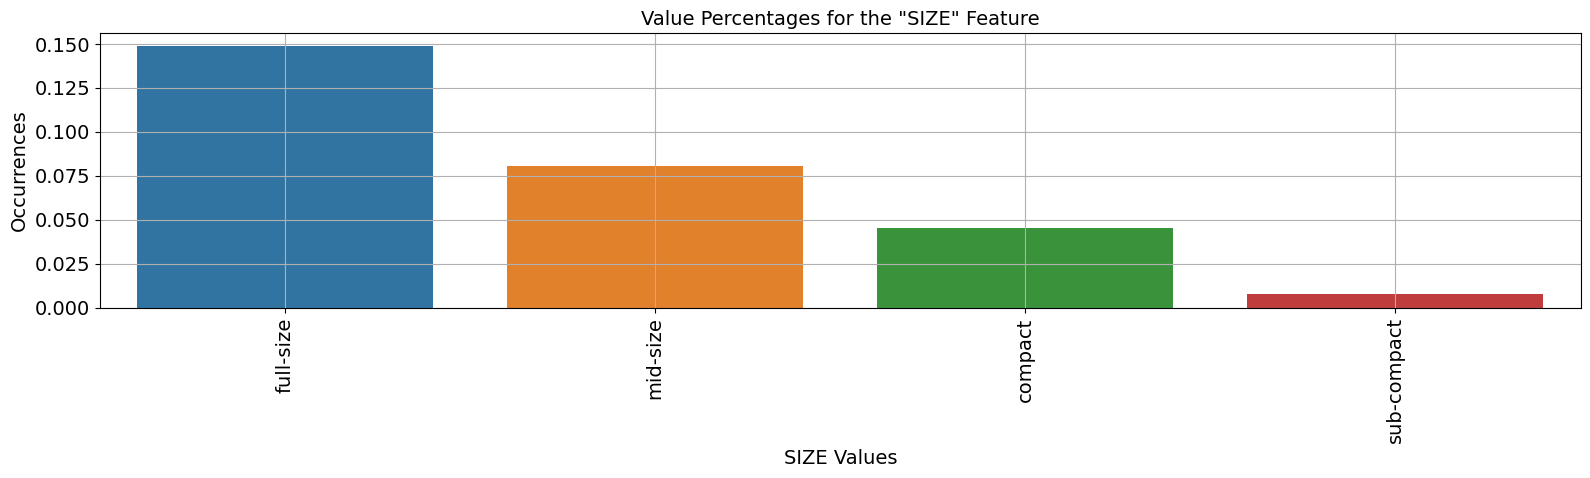

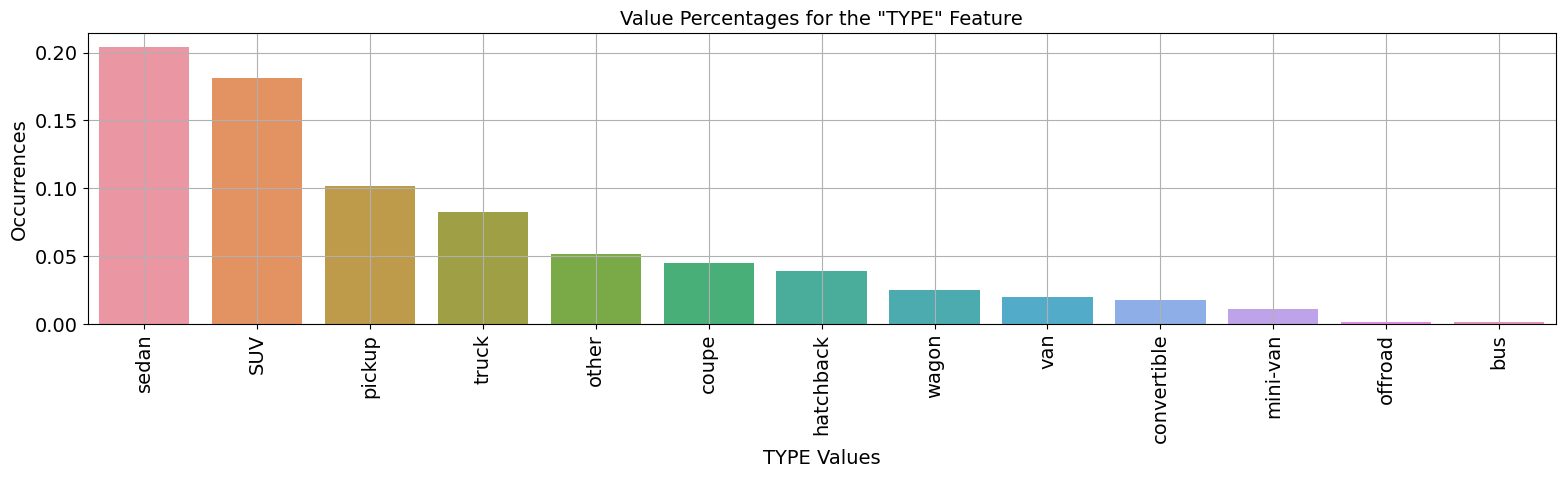

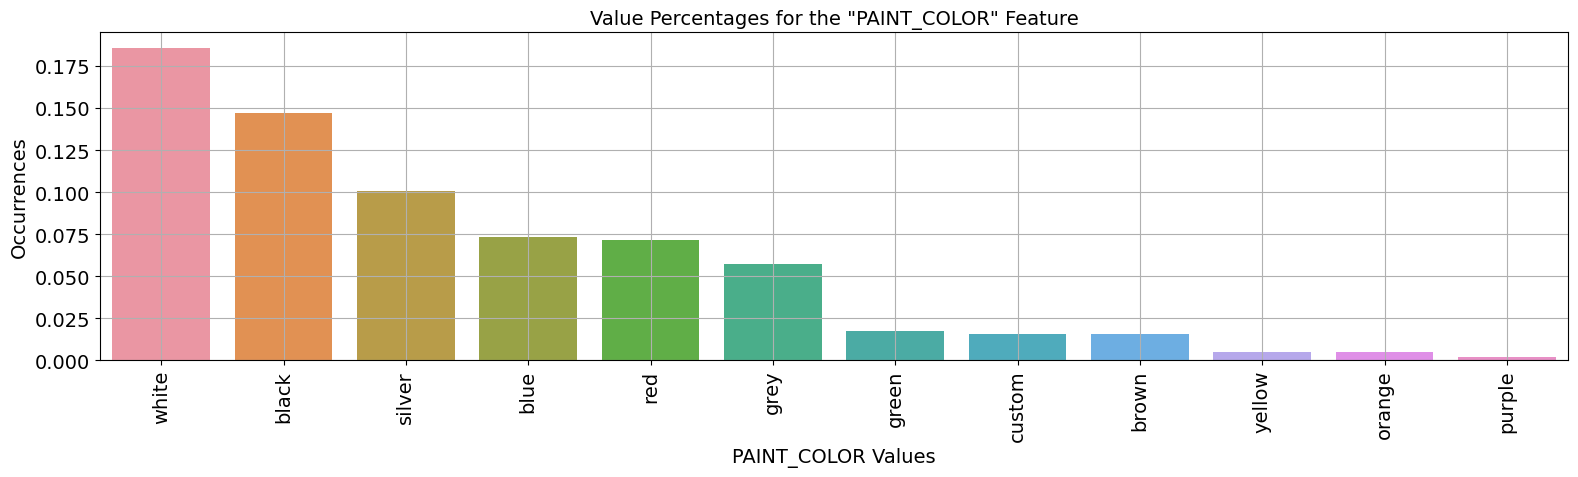

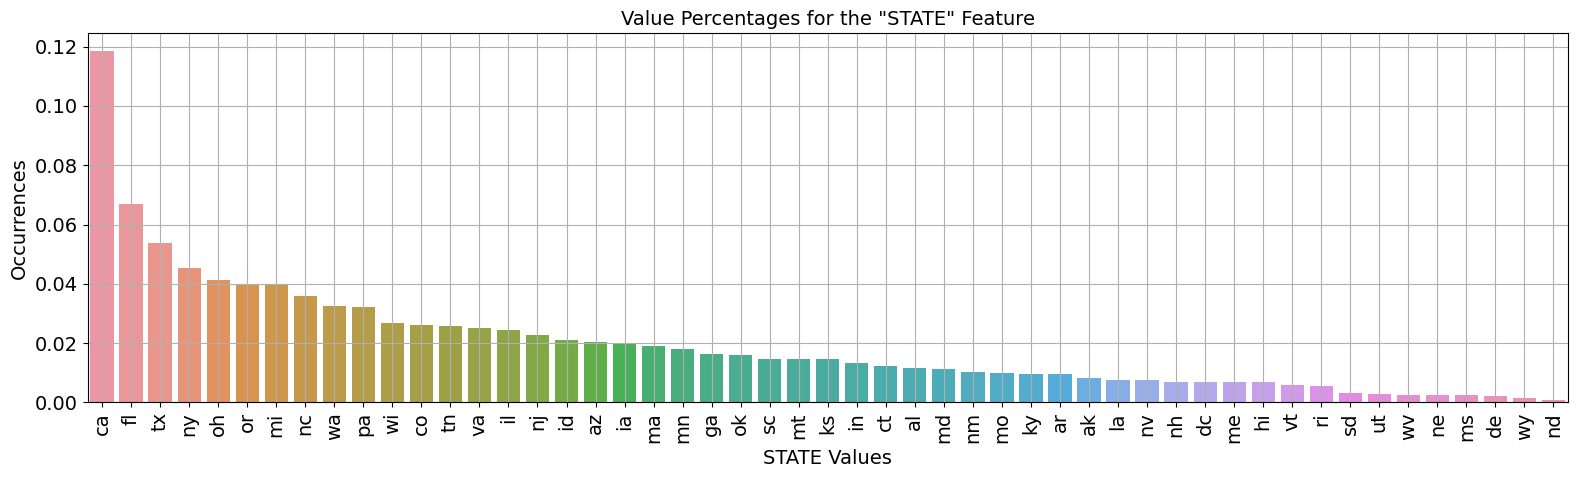

In [25]:

for cmv in cols_categorical:
    df_cmv = pd.DataFrame(df[cmv].value_counts( dropna=False, normalize=True ).sort_values( ascending=False )).reset_index()
    #df_cmv[cmv] = round( df_cmv[cmv] * 100, 3 )
    # print( helper_print_heading( f'Feature: {cmv}' ),
    #        #display( df_cmv )
    #      )
    ax = sns.barplot( df_cmv, y='proportion', x=cmv )
    #ax.bar_label(ax.containers[0])
    plt.title(f'Value Percentages for the "{cmv.upper()}" Feature' )
    plt.xlabel(f'{cmv.upper()} Values')
    plt.ylabel('Occurrences')
    plt.xticks(rotation=90)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'images/pa2-univariate-categorical-barplot-{cmv.lower()}.png')
    plt.show()


/──────────────────────────────────────────────────  FEATURE: PRICE  ──────────────────────────────────────────────────/



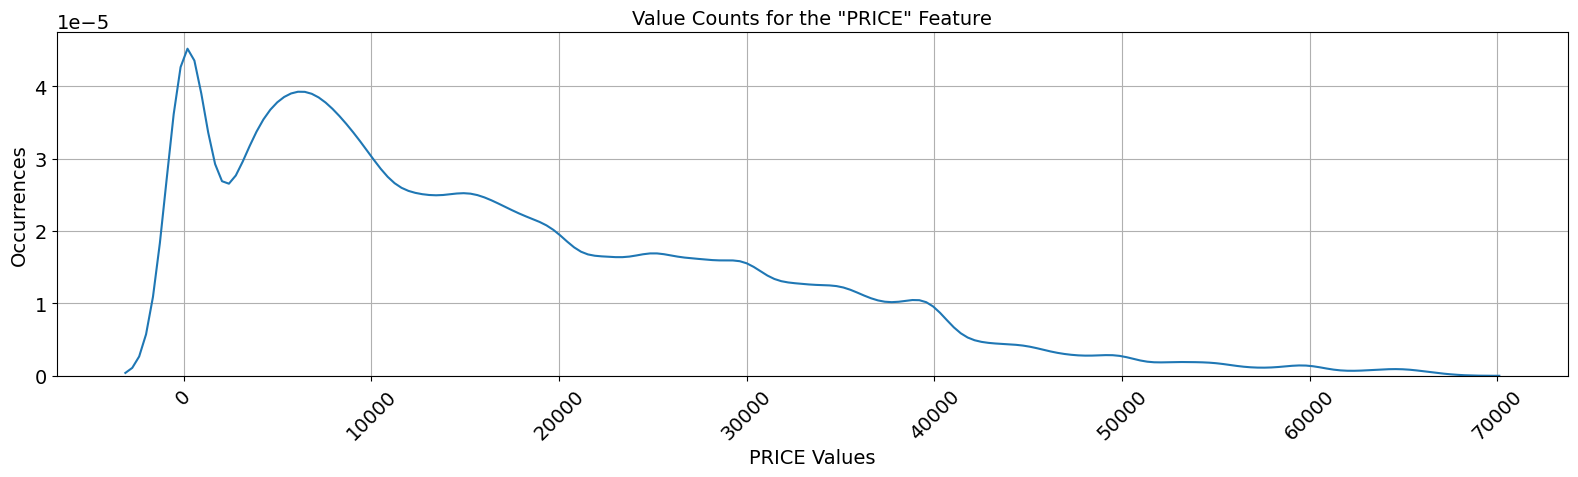


/──────────────────────────────────────────────────  FEATURE: YEAR  ──────────────────────────────────────────────────/



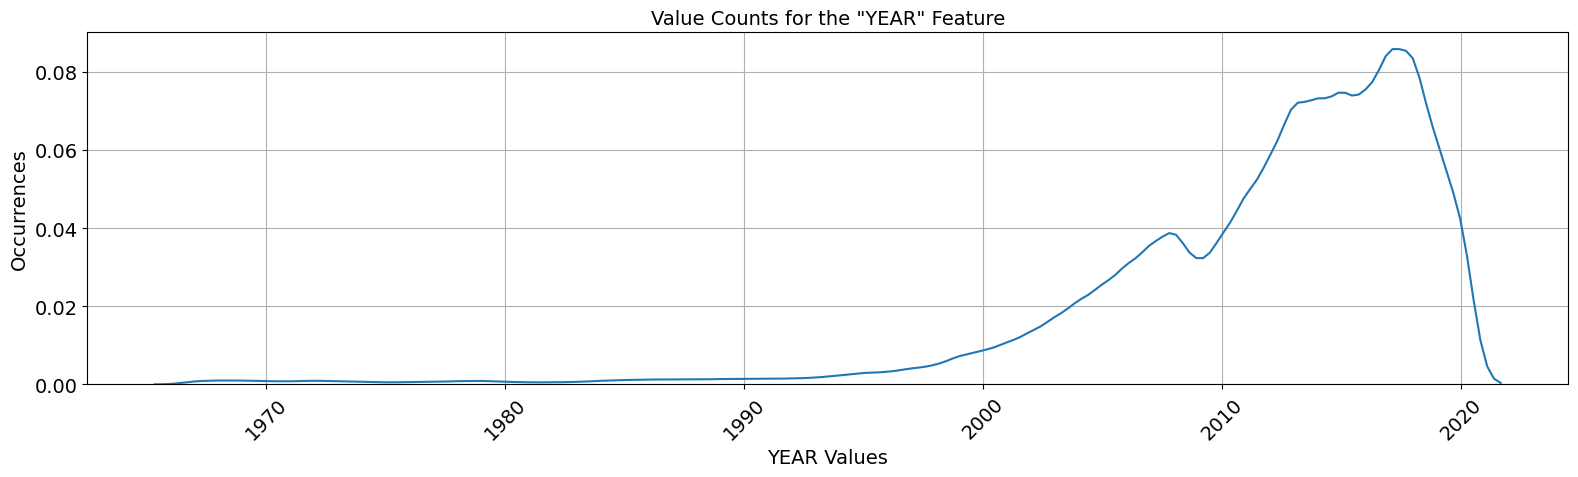


/────────────────────────────────────────────────  FEATURE: ODOMETER  ────────────────────────────────────────────────/



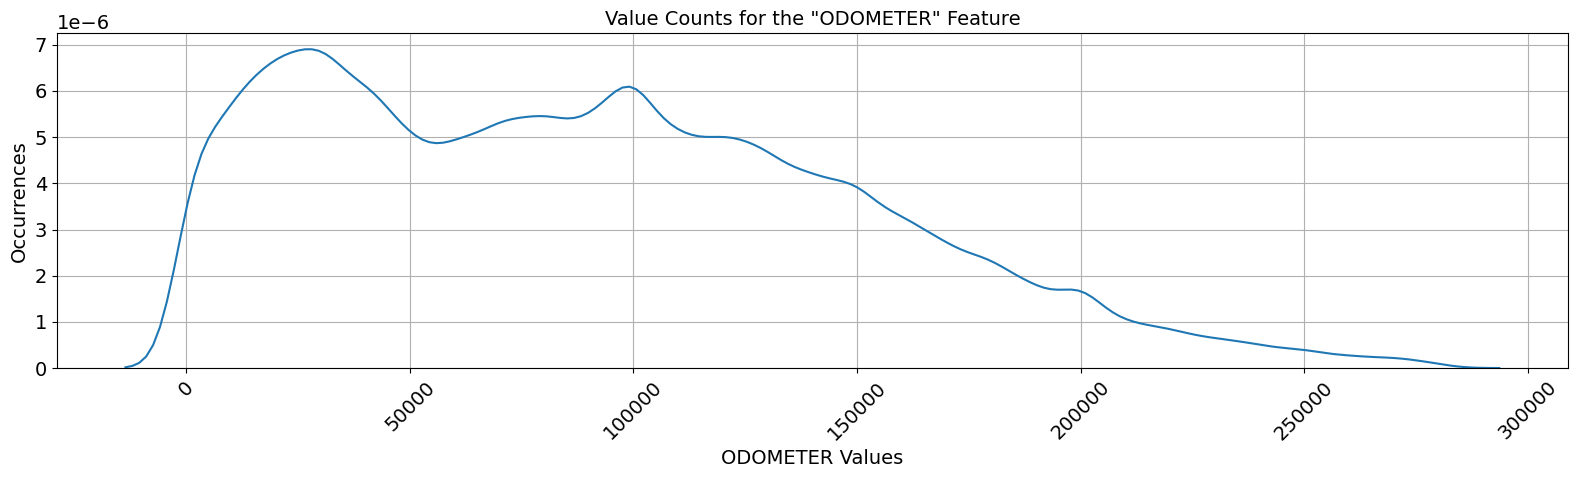

In [26]:
# Evaluate KDE
for cmv in cols_numerical:
    print( helper_print_heading( f'Feature: {cmv}' ))

    # drop outliers to see true shape, since outliers will be dropped later
    lower_limit = df[cmv].quantile(0.01)
    upper_limit = df[cmv].quantile(0.99)

    # Filter the DataFrame to exclude values outside the 2th-98th percentile range
    filtered_df = df[(df[cmv] >= lower_limit) & (df[cmv] <= upper_limit)]

    sns.kdeplot(data=filtered_df[cmv])
    plt.title(f'Value Counts for the "{cmv.upper()}" Feature' )
    plt.xlabel(f'{cmv.upper()} Values')
    plt.ylabel('Occurrences')
    plt.xticks(rotation=45)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'images/pa2-univariate-numerical-kde-plot-{cmv.lower()}.png')
    plt.show()

#### Bivariate Analysis
Explore a pair plot and correlation matrix to understand feature relationships with each other, as well as with the target feature, `price`

In [27]:
#sns.pairplot(df[cols_numerical])

<Axes: >

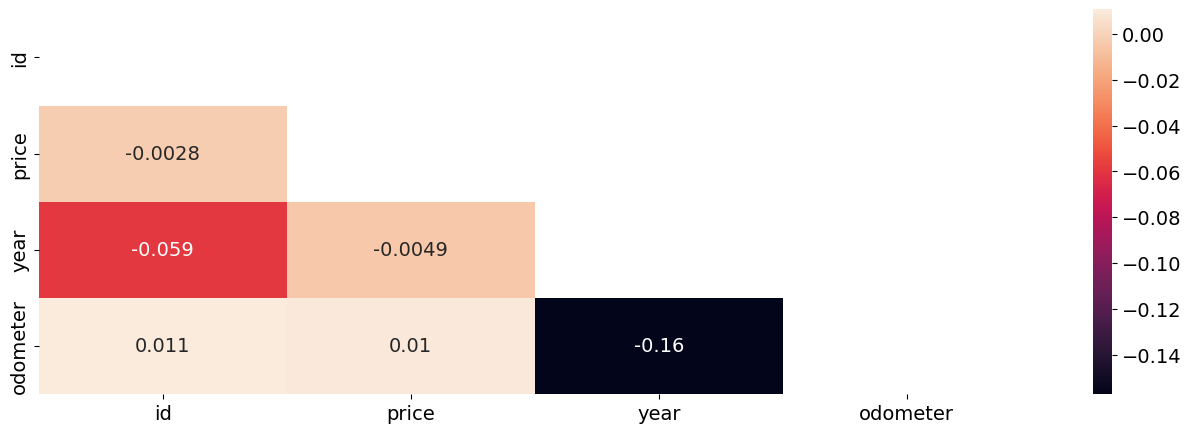

In [28]:
# Heatmap of Correlation coefficients
mask = np.triu(np.ones_like(df.corr(numeric_only=True).round(2)))
sns.heatmap(df.corr(numeric_only=True), mask=mask, annot=True)

# numerical features are not highly correlated

In [29]:
## Test with Polynomials
poly_cols = df.drop(['id', 'price'], axis=1).select_dtypes(exclude=["object"]).columns.tolist()
poly_transform = PolynomialFeatures(degree = 3, include_bias=False)
df_test_poly = pd.DataFrame( poly_transform.fit_transform( df[poly_cols].dropna() ), columns=poly_transform.get_feature_names_out() )
df_test_poly["price"] = df["price"]
display(df_test_poly)

,year,odometer,year^2,year odometer,odometer^2,year^3,year^2 odometer,year odometer^2,odometer^3,price
0,2014.0000,57923.0000,4056196.0000,116656922.0000,3355073929.0000,8169178744.0000,234947040908.0000,6757118893006.0000,194335947189467.0000,6000
1,2010.0000,71229.0000,4040100.0000,143170290.0000,5073570441.0000,8120601000.0000,287772282900.0000,10197876586410.0000,361385348941989.0000,11900
2,2020.0000,19160.0000,4080400.0000,38703200.0000,367105600.0000,8242408000.0000,78180464000.0000,741553312000.0000,7033743296000.0000,21000
3,2017.0000,41124.0000,4068289.0000,82947108.0000,1691183376.0000,8205738913.0000,167304316836.0000,3411116869392.0000,69548225154624.0000,1500
4,2013.0000,128000.0000,4052169.0000,257664000.0000,16384000000.0000,8157016197.0000,518677632000.0000,32980992000000.0000,2097152000000000.0000,4900
...,...,...,...,...,...,...,...,...,...,...
421339,2019.0000,32226.0000,4076361.0000,65064294.0000,1038515076.0000,8230172859.0000,131364809586.0000,2096761938444.0000,33467186839176.0000,12980
421340,2020.0000,12029.0000,4080400.0000,24298580.0000,144696841.0000,8242408000.0000,49083131600.0000,292287618820.0000,1740558300389.0000,12980
421341,2020.0000,4174.0000,4080400.0000,8431480.0000,17422276.0000,8242408000.0000,17031589600.0000,35192997520.0000,72720580024.0000,18980
421342,2018.0000,30112.0000,4072324.0000,60766016.0000,906732544.0000,8217949832.0000,122625820288.0000,1829786273792.0000,27303530364928.0000,17980


<Axes: >

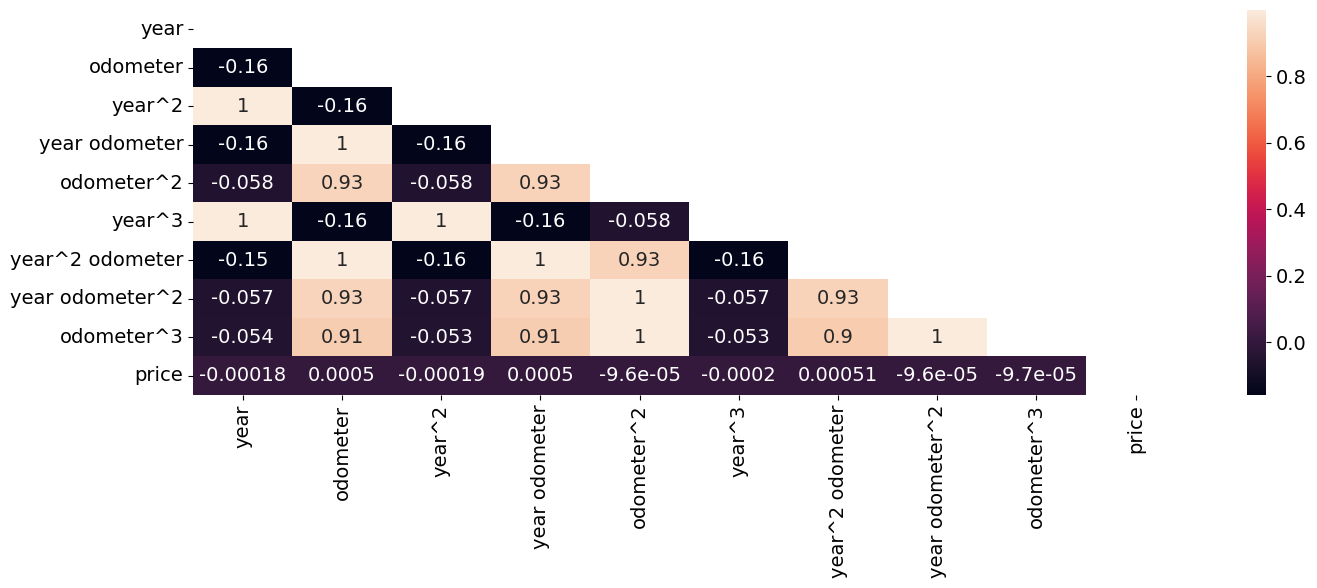

In [30]:
# Heatmap of Correlation coefficients for Polynomials test
mask = np.triu(np.ones_like(df_test_poly.corr(numeric_only=True).round(2)))
sns.heatmap(df_test_poly.corr(numeric_only=True), mask=mask, annot=True)


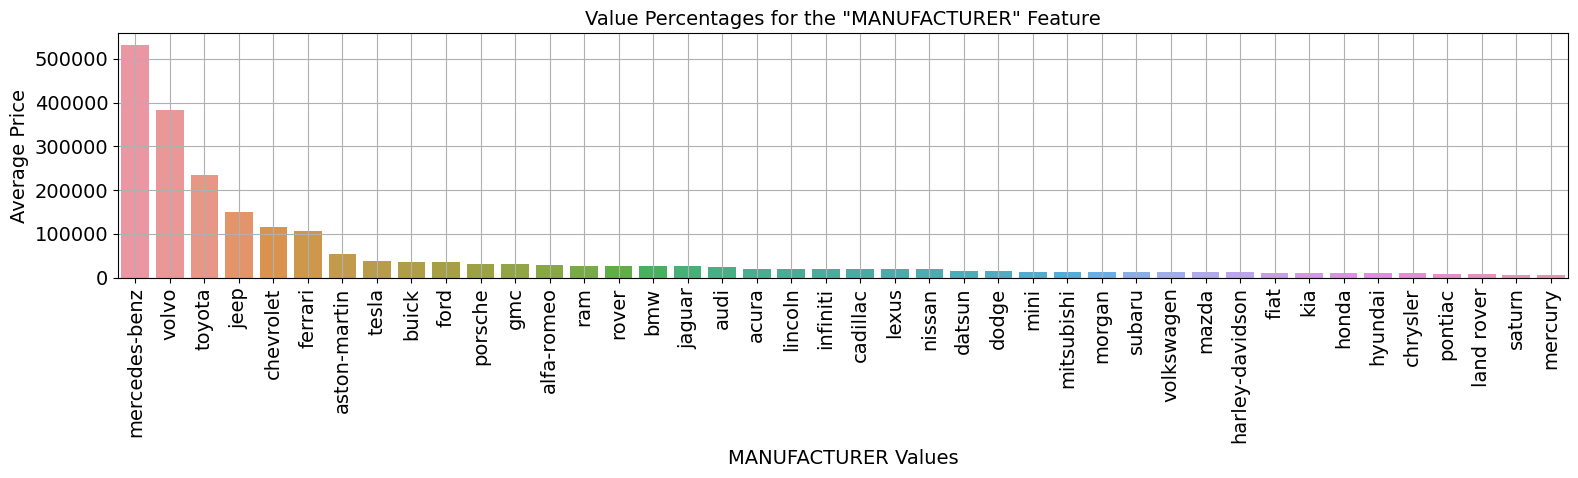

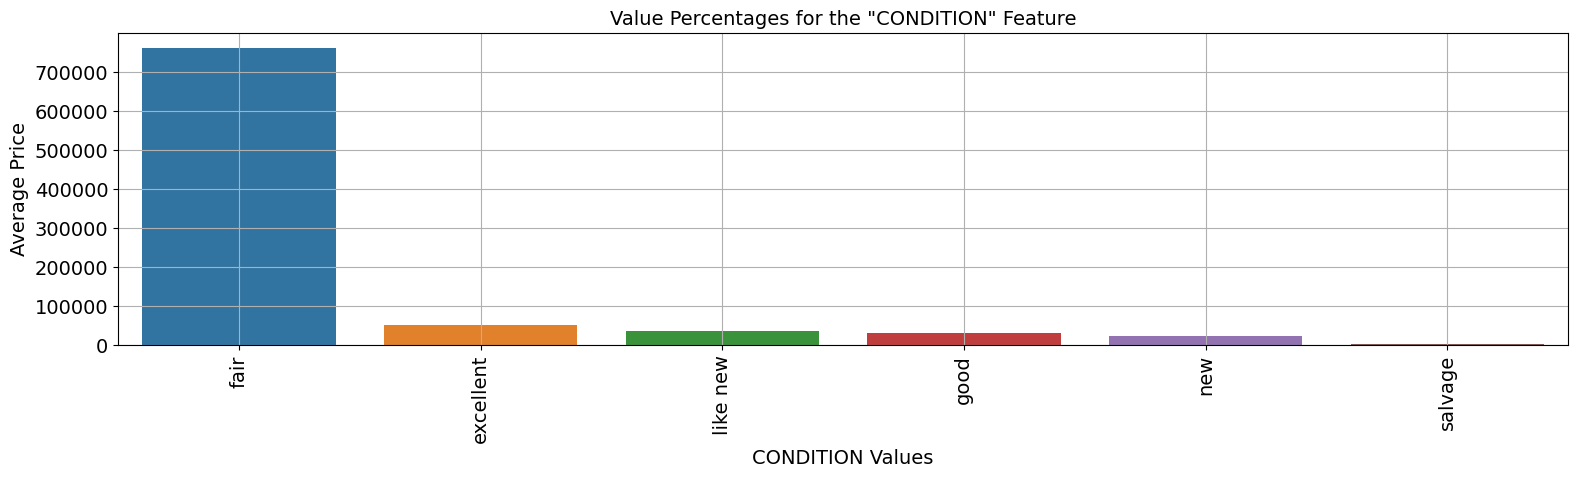

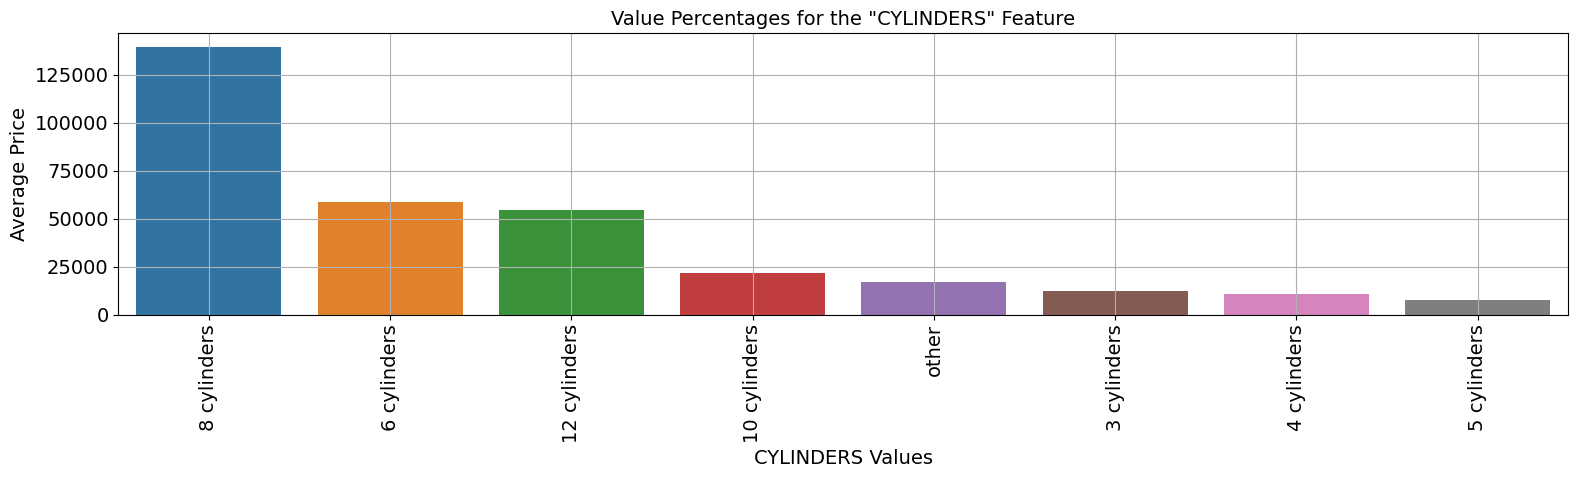

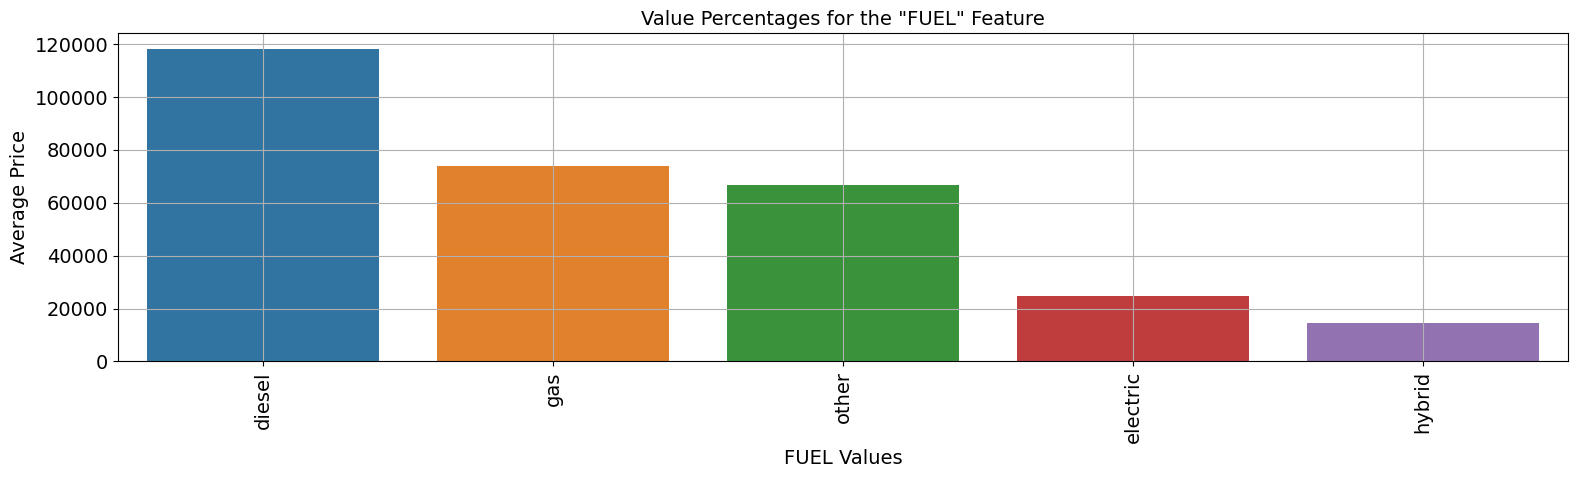

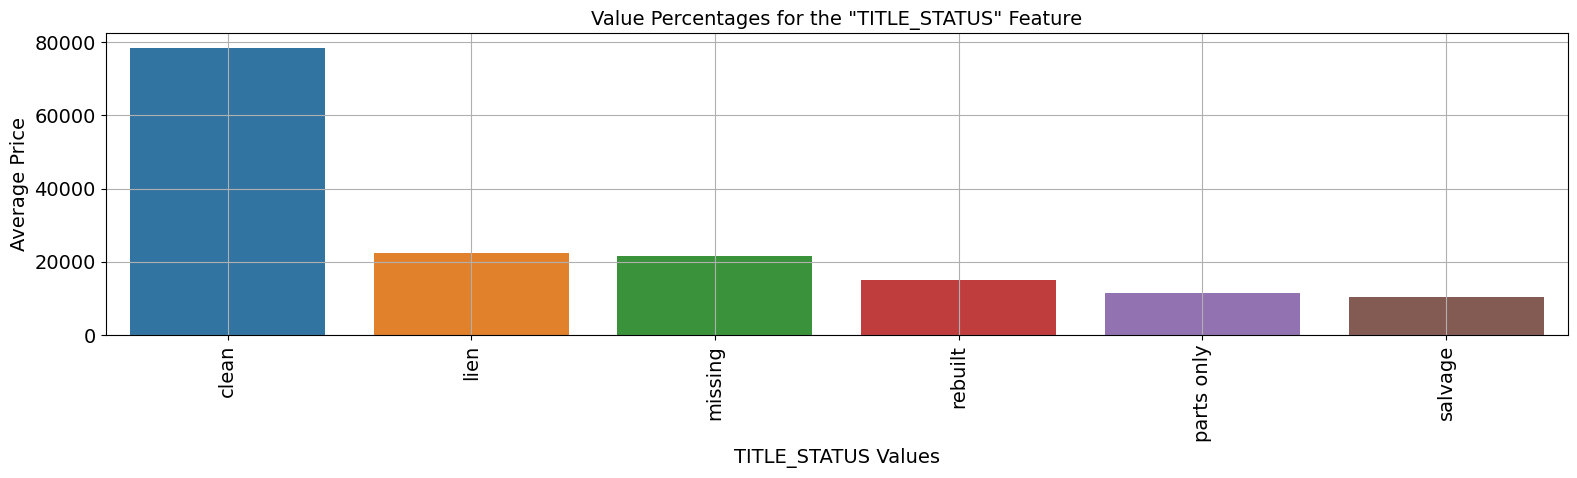

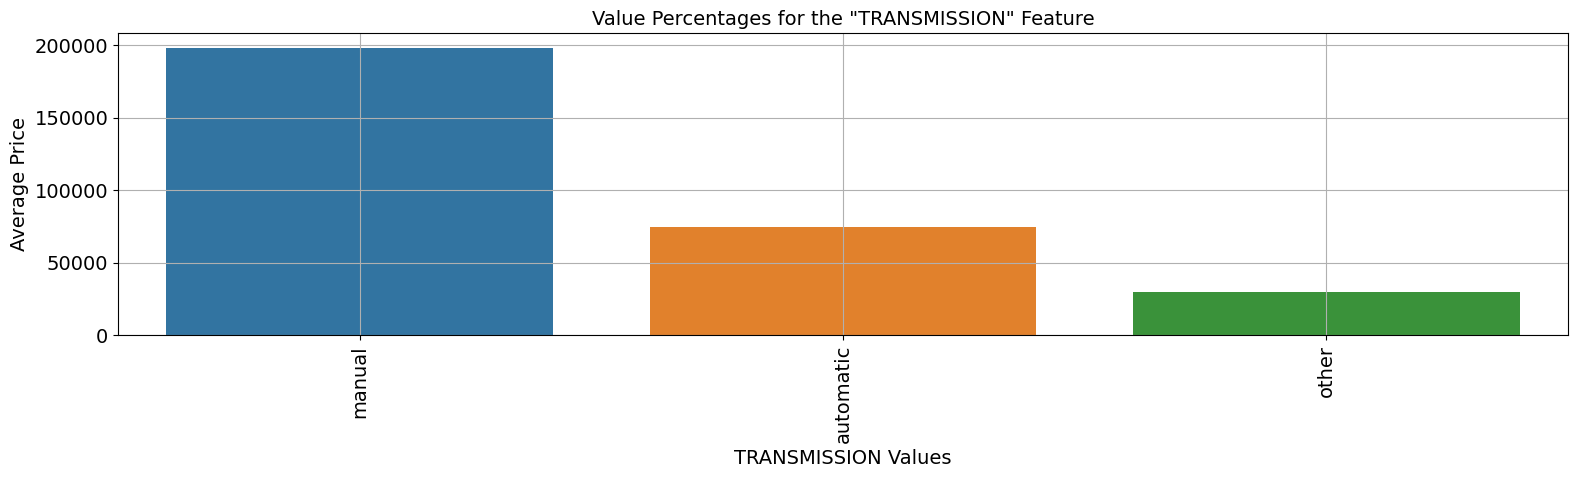

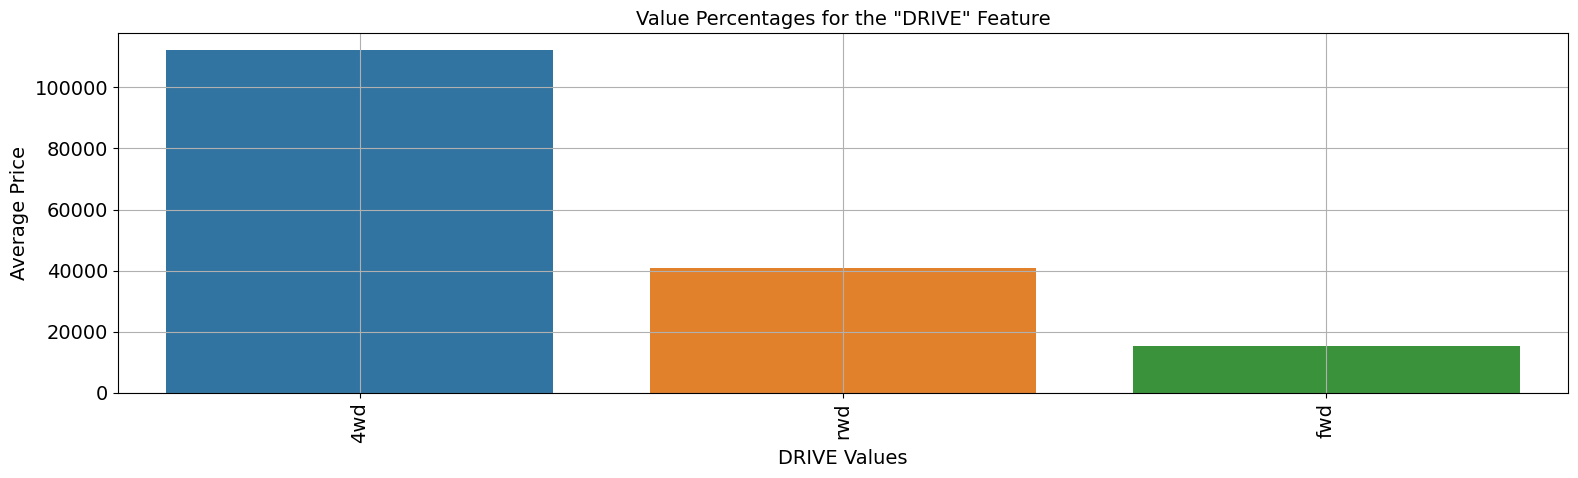

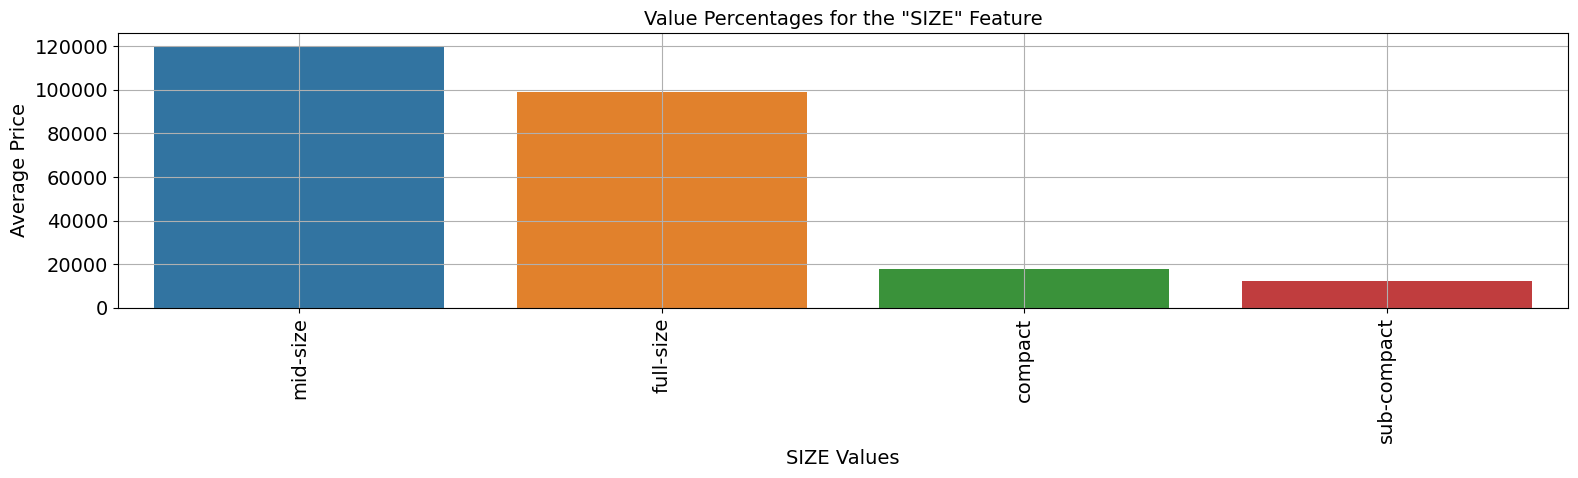

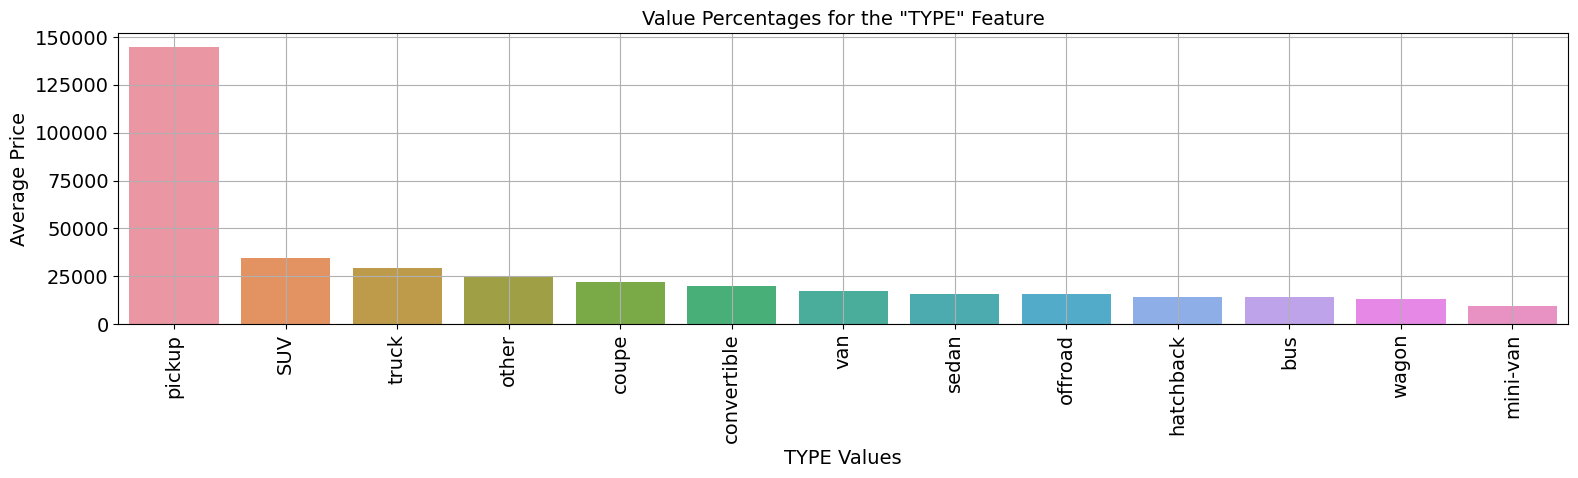

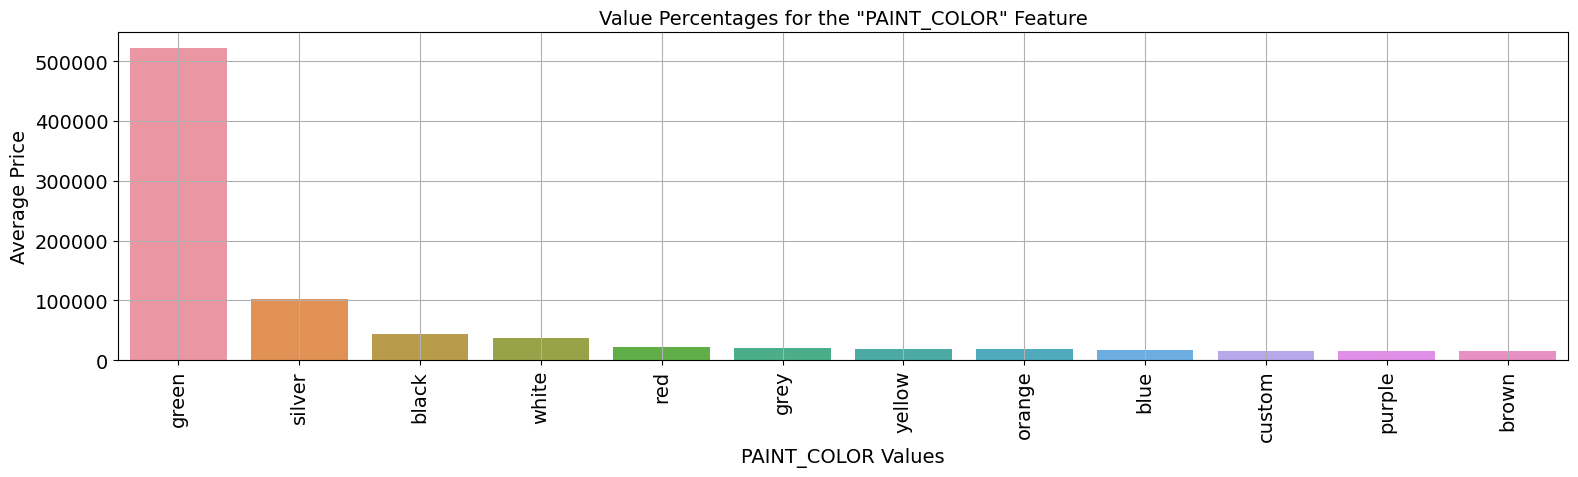

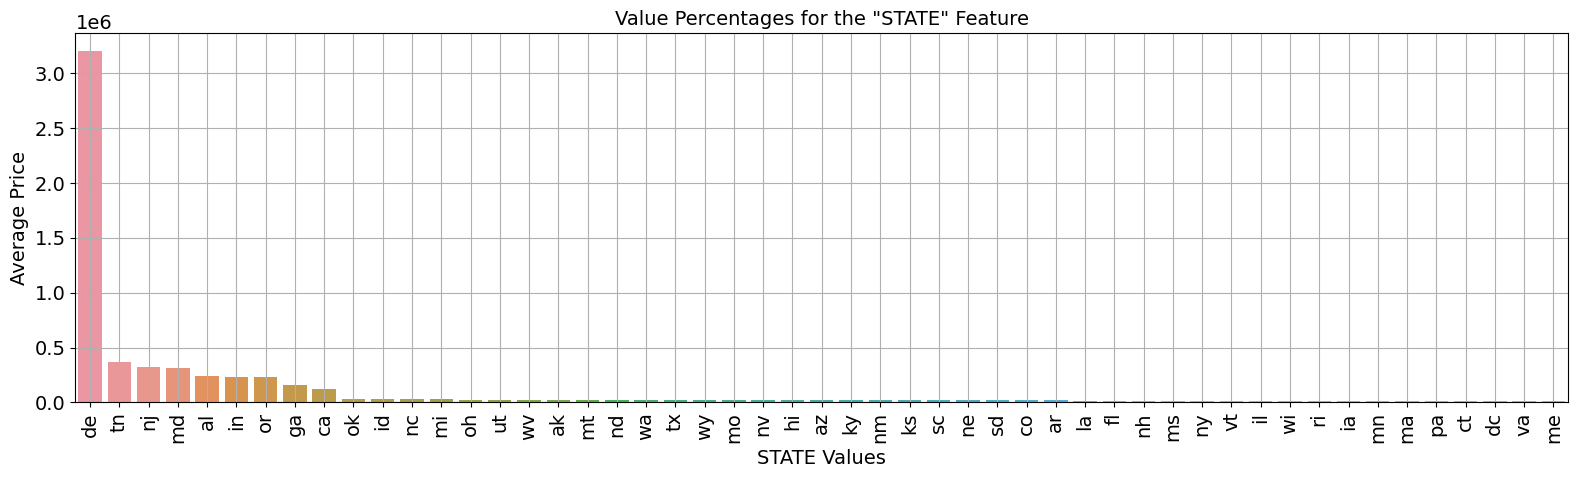

In [31]:
# Evaluate categorical features for average pricing
for cmv in cols_categorical:
    df_cmv = df.groupby(cmv)[['price']].mean().reset_index().sort_values('price', ascending=False)
    df_cmv['price'] = round( df_cmv['price'], 0 )
    # print( helper_print_heading( f'Feature: {cmv}' ),
    #        display( df_cmv )
    #      )
    
    ax = sns.barplot( df_cmv, y='price', x=cmv )
    #ax.bar_label(ax.containers[0])
    plt.title(f'Value Percentages for the "{cmv.upper()}" Feature' )
    plt.xlabel(f'{cmv.upper()} Values')
    plt.ylabel('Average Price')
    plt.xticks(rotation=90)
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'images/pa2-bivariate-avgprice-categorical-barplot-{cmv.lower()}.png')
    plt.show()

#### Evaluate Target Feature ("price")

In [32]:
df["price"].describe([.01, .05, .1, .15, .85, .90, .95, .96, .97, .98, .99, .999, 0.9999])

# large number of records are at the extreme values, they may negatively impact predictions; investigate further

count        426880.0000
mean          75199.0332
std        12182282.1736
min               0.0000
1%                0.0000
5%                0.0000
10%             500.0000
15%            3000.0000
50%           13950.0000
85%           32995.0000
90%           37590.0000
95%           44500.0000
96%           46995.0000
97%           50666.7000
98%           56900.0000
99%           66995.0000
99.9%        120000.0000
99.99%      1234567.0000
max      3736928711.0000
Name: price, dtype: float64

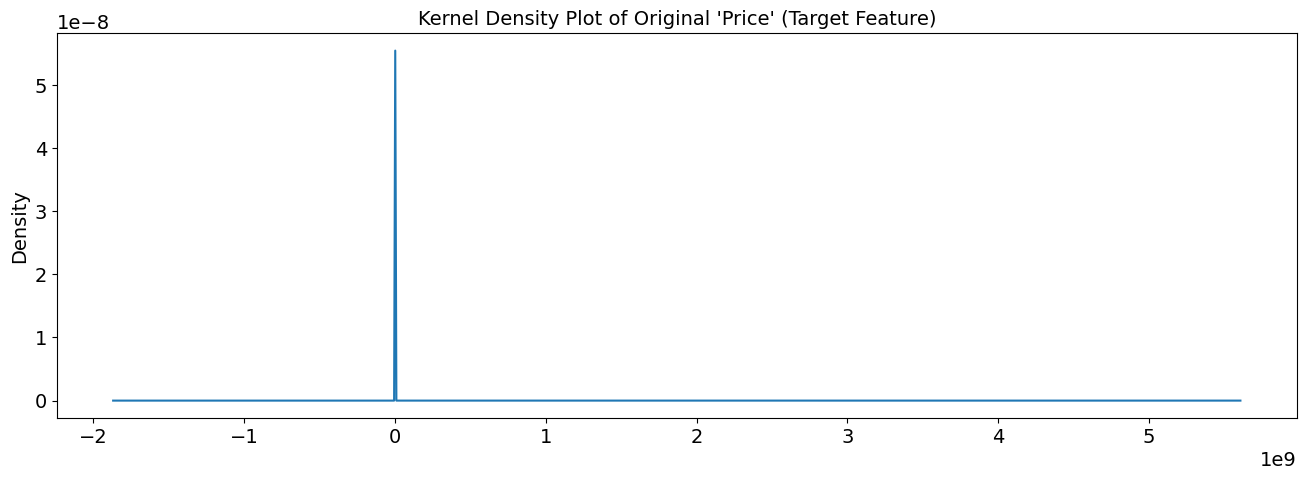

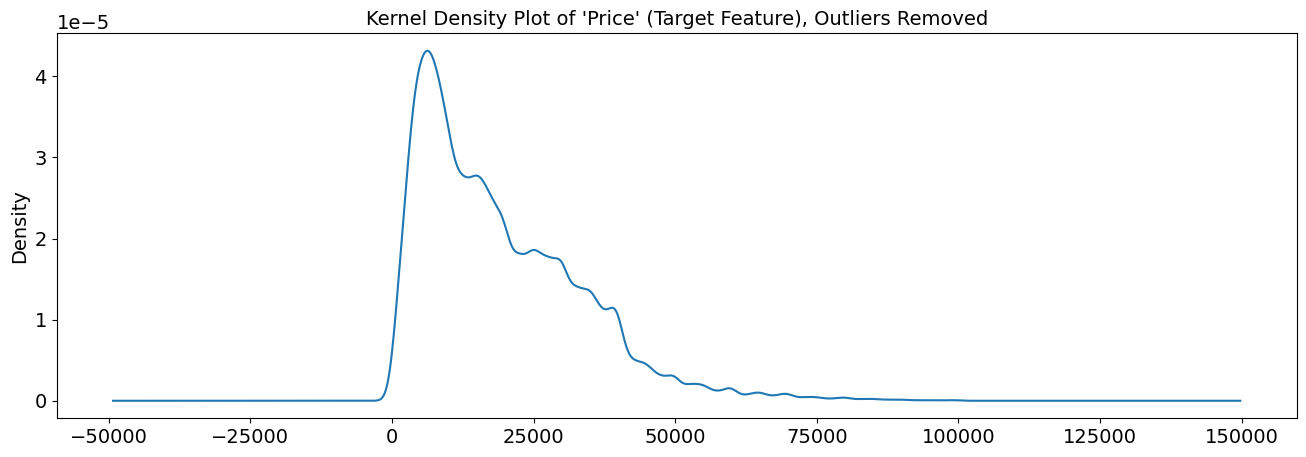

In [33]:
df["price"].plot(kind="kde")
plt.title("Kernel Density Plot of Original 'Price' (Target Feature)")
plt.show()

df.query("500 < price < 100_000")["price"].plot(kind="kde")
plt.title("Kernel Density Plot of 'Price' (Target Feature), Outliers Removed")
plt.show()

# As demonstrated above in univariate analysis, a large amount of outliers will negatively impact the model, we'll drop these outliers before modeling begins.

In [34]:
df.sort_values('price', ascending=False).head(20)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
318592,7308056031,eugene,3736928711,2007.0000,toyota,tundra,excellent,8 cylinders,gas,164000.0000,clean,automatic,NaN,4wd,full-size,pickup,silver,or
356716,7302445002,knoxville,3736928711,1999.0000,toyota,4runner,fair,6 cylinders,gas,211000.0000,clean,automatic,NaN,4wd,mid-size,NaN,green,tn
257840,7309735768,south jersey,3024942282,2000.0000,mercedes-benz,benz s430,NaN,NaN,gas,100000.0000,clean,automatic,NaN,NaN,NaN,NaN,NaN,nj
91576,7309730903,delaware,3024942282,2000.0000,mercedes-benz,benz e320,NaN,NaN,gas,100000.0000,clean,automatic,NaN,NaN,NaN,NaN,NaN,de
37410,7314052904,modesto,3009548743,2021.0000,chevrolet,NaN,NaN,8 cylinders,gas,1000.0000,clean,automatic,NaN,4wd,NaN,NaN,NaN,ca
184704,7304345156,frederick,1410065407,1989.0000,jeep,wrangler,NaN,NaN,diesel,103000.0000,clean,manual,NaN,NaN,NaN,SUV,NaN,md
153082,7305153975,indianapolis,1234567890,2006.0000,volvo,vnl,fair,NaN,other,200000.0000,clean,manual,NaN,NaN,NaN,NaN,black,in
29386,7305265540,humboldt county,1111111111,1999.0000,ford,f350 super duty lariat,good,8 cylinders,diesel,149000.0000,clean,automatic,NaN,rwd,full-size,pickup,white,ca
37409,7314053169,modesto,1111111111,2020.0000,jeep,NaN,NaN,NaN,gas,1000.0000,clean,automatic,NaN,4wd,NaN,NaN,NaN,ca
122470,7315836487,atlanta,987654321,1960.0000,chevrolet,NaN,NaN,NaN,gas,9999999.0000,clean,manual,NaN,NaN,NaN,NaN,NaN,ga


In [35]:
df.query('manufacturer == "toyota" and type=="pickup"').sort_values("price", ascending=False)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
318592,7308056031,eugene,3736928711,2007.0000,toyota,tundra,excellent,8 cylinders,gas,164000.0000,clean,automatic,NaN,4wd,full-size,pickup,silver,or
77353,7315739084,denver,63000,2021.0000,toyota,tundra,new,8 cylinders,gas,500.0000,lien,automatic,NaN,4wd,NaN,pickup,grey,co
131301,7315740268,boise,63000,2021.0000,toyota,tundra,new,8 cylinders,gas,1800.0000,lien,automatic,NaN,4wd,NaN,pickup,grey,id
129312,7314964390,hawaii,61999,2020.0000,toyota,tundra,NaN,NaN,gas,7267.0000,clean,NaN,5TFDY5F18LX886667,4wd,NaN,pickup,NaN,hi
130280,7313649244,hawaii,59999,2018.0000,toyota,tundra,NaN,NaN,gas,27893.0000,clean,NaN,5TFDY5F16JX754794,4wd,NaN,pickup,NaN,hi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132354,7314367700,boise,0,2014.0000,toyota,tacoma,excellent,NaN,gas,NaN,clean,automatic,NaN,4wd,NaN,pickup,NaN,id
371263,7314998530,dallas / fort worth,0,2014.0000,toyota,tacoma,NaN,NaN,gas,NaN,clean,automatic,NaN,4wd,NaN,pickup,grey,tx
397488,7304921637,richmond,0,2015.0000,toyota,tacoma,NaN,NaN,gas,83926.0000,clean,automatic,5TFJX4GN9FX042482,fwd,NaN,pickup,white,va
359275,7315330356,nashville,0,2008.0000,toyota,tundra 2008,NaN,8 cylinders,gas,154700.0000,rebuilt,automatic,NaN,rwd,full-size,pickup,blue,tn


In [36]:
# Model fit failed due to a OHE category value only existing in the training set
# Likely due to poor train/test split for those lower count values
# Examine and drop any values that risk not existing in both sets to progress, but
# consider if another means to distribute all values to both sets

df['manufacturer'].value_counts().sort_values()

manufacturer
morgan                 3
land rover            21
aston-martin          24
datsun                63
ferrari               95
harley-davidson      153
fiat                 792
tesla                868
alfa-romeo           897
saturn              1090
mercury             1184
porsche             1384
jaguar              1946
rover               2113
pontiac             2288
mini                2376
mitsubishi          3292
volvo               3374
lincoln             4220
infiniti            4802
mazda               5427
buick               5501
acura               5978
chrysler            6031
cadillac            6953
audi                7573
lexus               8200
kia                 8457
volkswagen          9345
subaru              9495
hyundai            10338
mercedes-benz      11817
dodge              13707
bmw                14699
gmc                16785
ram                18342
jeep               19014
nissan             19067
honda              21269
toyota      

In [37]:
df.sort_values('price', ascending=True).head(20)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
335266,7307704873,philadelphia,0,2012.0000,infiniti,g37x awd,NaN,NaN,gas,131922.0000,clean,automatic,NaN,NaN,NaN,NaN,NaN,pa
97994,7316671228,jacksonville,0,2016.0000,ford,f-150,NaN,NaN,NaN,NaN,NaN,NaN,1FTEW1CF0GFA87903,NaN,NaN,NaN,NaN,fl
97995,7316671091,jacksonville,0,2016.0000,mercedes-benz,c-class,NaN,NaN,NaN,NaN,NaN,NaN,55SWF4JB7GU157731,NaN,NaN,NaN,NaN,fl
97996,7316670635,jacksonville,0,2017.0000,toyota,camry,like new,6 cylinders,gas,80000.0000,clean,automatic,NaN,fwd,full-size,sedan,silver,fl
356355,7304587188,knoxville,0,2008.0000,nissan,armada se,good,8 cylinders,gas,224444.0000,clean,automatic,5N1AA08D38N613507,rwd,NaN,SUV,NaN,tn
98028,7316525138,jacksonville,0,2015.0000,acura,rdx,like new,6 cylinders,gas,50000.0000,clean,automatic,NaN,fwd,mid-size,SUV,white,fl
356354,7304587203,knoxville,0,2015.0000,mini,cooper s countryman base,good,NaN,gas,60789.0000,clean,automatic,WMWZC3C51FWT02407,fwd,NaN,other,blue,tn
356353,7304587197,knoxville,0,2016.0000,ford,mustang ecoboost premium,good,NaN,gas,49212.0000,clean,manual,1FA6P8TH8G5223153,rwd,NaN,coupe,orange,tn
356352,7304587215,knoxville,0,2019.0000,ford,mustang ecoboost,good,NaN,gas,4214.0000,clean,manual,1FA6P8TH4K5203748,rwd,NaN,coupe,black,tn
356346,7304629385,knoxville,0,2018.0000,nissan,rogue,NaN,NaN,gas,46424.0000,clean,automatic,5N1AT2MT6JC849198,fwd,NaN,NaN,NaN,tn


#### Observations and Conclusions

##### Data Integrity:
The following actions will be completed in the listed order, as sequence of steps will be relevant to maximize the amount of useful remaining data to model from:

1. ***Unreliable features to cleanse:*** 
    * `VIN` feature's value review indicates that the same specific vehicle (unique VIN) may have been listed in multiple locations, and therefore we cannot rely on `region` or `state` columns when modeling as we're not clear on where it was ultimately sold. 
    * This observation is confirmed by reviewing number of duplicated records when `region` and `state` fields are dropped, and all others remain as-is, queried by `VIN` value (e.g. "3C6JR6DT3KG560649")
    * To correct this, for any `VIN` values that occur more than once, only the first one will be retained, the duplicated records will be dropped to preserve the integrity of `region` and `state` features
2. ***Unneeded features:*** Drop the `id` and `model` features:
    * `id` feature is not valuable for modeling, as it's simply a record identifier
    * `model` feature has over 29k unique values, where it seems a fair amount of variants -- requires heavy sanitization with unclear value thereafter, so dropping the feature for current modeling exercise.
3. ***Drop duplicate records***
    * We drop duplicates with `VIN` feature still present, as it helps to properly qualify similar cars (duplicate records), when region/state are not factors.
4. ***Drop the `VIN` column:***
    * Also dropping `VIN` since by it's definition, it's a unique value, and has 38% of it's values missing
5. ***Imputing or dropping remaining missing values***: This dataset is missing a significant amount of values across multiple features. 
    * When reviewing the missing value data by impacted features, it seems more desirable to keep as many records intact by imputing values for both numerical and categorical features with missing values.
    * From reviewing a heatmap of missing data within this dataset, only records missing more than 12 features will be dropped, to preserve as much useful data as possible for modeling (`dropna(thresh=13)`)

##### Univariate Analysis:
1. Cars manufactured by ***Ford***, ***Chevrolet*** and ***Honda*** were most available for resale, totaling approximately 38% of the total used car market. (`manufacturer`)
2. When car condition was recorded, the vast majority were in either ***good*** or ***excellent*** condition. (`condition`)
3. When the number of cylinders was recorded, ***6-cylinder*** cars were the most common (22%), closely followed by ***4-cylinder*** (18%) and ***8-cylinder*** (17%) cars. (`cylinders`)
4. Cars fueled by *******gas******* were most abundant (83%), as expected, since internal combustion engines have been the primary engine type outside of the past few years. Any recommendations around fuel type will likely evolve as more EV and hybrid vehicles cycle through lease and resale markets in upcoming years. (`fuel`)
5. Almost 95% of all available used cars indicated a ***************clean*************** car title, necessary for smooth transfer of ownership upon purchase. (`title_status`)
6. Unsurprisingly, ***automatic*** transmissions were most common in used cars (79%). (`transmission`)
7. When the drivetrain type was indicated, ***4wd*** used cars were most common (~31%), followed by front-wheel drive (***fwd***, 25%), and then rear-wheel drive (***rwd***, 14%) (`drive`)
8. When car size classes were indicated, ***full-size*** cars were available almost 84% or higher than other vehicle size classes, followed by ***mid-size***, ***compact***, and ***sub-compact***, respectively. (`size`)
9. Aligned with above observations regarding size, drivetrain, and cylinders, when car type was indicated, ***sedans***, ***SUVs*** and ***pickups*** comprised almost 50% of all available cars. (`type`)
10. When car color was indicated, ***white***, ***black,*** and ***silver*** were most common (respectively), representing over 43% of available cars. (`paint_color`)
11. The target feature, the car’s price, contains extreme values, as well as what appear to be artificial values (e.g. $111111) which will impair the model’s ability to properly predict pricing based on the car’s features. (`price`)

##### Bivariate Analysis:
1. When evaluating ***correlations*** between the original numeric variables, no variables seemed to be strongly correlated to another; none of the variables demonstrated multicollinearity.

##### Feature Engineering:
1. For `transmission` feature, simplify values to `automatic` or `not automatic`, as preparation for onehot-encoding.
2. For `title_status` feature, simplify values to `clean` or `not clean`, as preparation for onehot-encoding.
3. For `price` feature, create a categorization feature to classify "valid" price from from "unrealistic"
4. For `condition` feature, combine values that seem to be synonyms, e.g. "new" and "excellent"

    

## Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [38]:
# Create a copy to start preparing data
df_dropped = df.copy()

### Drop Feature Columns That Will Not Benefit Modeling
* Based on the above understanding, we'll update our dataset to remove `id`, `model` features as the number of unique values is too high to be useful in models

In [39]:
# Clean up VIN duplicate records:
print("Initial Number of Duplicates for VINs: ", df_dropped["VIN"].isna().sum())
unique_vins = sorted( df_dropped.groupby("VIN")["id"].idxmin().tolist() )
df_dropped = df_dropped[df_dropped.index.isin( unique_vins )].sort_index()
print("Final Number of Duplicates for VINs: ", df_dropped["VIN"].isna().sum())

Initial Number of Duplicates for VINs:  161042
Final Number of Duplicates for VINs:  0


In [40]:
# Note: We are not yet dropping `VIN`, since it's useful to more accurately find duplicate records to drop
df_dropped.drop(["id", "VIN", "model"], axis=1, inplace = True )
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118246 entries, 75 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        118246 non-null  object 
 1   price         118246 non-null  int64  
 2   year          117652 non-null  float64
 3   manufacturer  115181 non-null  object 
 4   condition     61104 non-null   object 
 5   cylinders     70378 non-null   object 
 6   fuel          116632 non-null  object 
 7   odometer      116725 non-null  float64
 8   title_status  114613 non-null  object 
 9   transmission  117026 non-null  object 
 10  drive         90796 non-null   object 
 11  size          30283 non-null   object 
 12  type          102189 non-null  object 
 13  paint_color   87485 non-null   object 
 14  state         118246 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 14.4+ MB


In [41]:
df_dropped.duplicated().sum(), df_dropped.shape

(184, (118246, 15))

In [42]:
df_dropped.drop_duplicates( inplace = True )
df_dropped.duplicated().sum(), df_dropped.shape

(0, (118062, 15))

In [43]:
# Recheck for duplicates and missing values
df_dropped.duplicated().sum(), df_dropped.isna().sum()

(0,
 region              0
 price               0
 year              594
 manufacturer     3057
 condition       57020
 cylinders       47768
 fuel             1571
 odometer         1447
 title_status     3563
 transmission     1175
 drive           27342
 size            87796
 type            15982
 paint_color     30611
 state               0
 dtype: int64)

### Feature Engineering

#### Feature cleanup
* To guard against unseen categories fit() errors after OHE `manufacturer`, remove any values with counts less than 10.
* Identify and drop records where `price` (target feature) values are outliers or unrealistic.
* Identify and drop records where `odometer` values are outliers or unrealistic.
#### Create new features
* Create `category` from `year`, mapped into vintage, antique, classic or contemporary categories
* Simplify values for `transmission` and `title` by keeping the most occurring value, and coalescing all other values into it's "not" value
* Create new `price_eval` feature to understand (and remove) records where the price value seems irregular and may negatively impact the model
* Map synonym values for `condition` to reduce number of unique values

In [44]:
# Drop any records where a value for `manufacturer` occurs less than 10 times
manuf_counts = df_dropped['manufacturer'].value_counts()
manuf_values_drop = manuf_counts[manuf_counts < 10].index
df_dropped = df_dropped[~df_dropped['manufacturer'].isin( manuf_values_drop )]

In [45]:
# Create new `price_eval` feature, which is a reflection of checking each records price against the `check_sequence()` custom function
df_dropped["price_eval"] = df_dropped['price'].apply( check_sequence )

# check how many records are flagged as non-valid price values based on the rules of the custom function `check_sequence()`
display( df_dropped["price_eval"].value_counts() )

# Query to only slice records with prices that seem "valid", to model
df_dropped = df_dropped.query("price_eval == 'valid'").copy()

price_eval
valid              101503
low                 15856
repeating             512
high                  162
sequence (asc)         19
sequence (desc)         7
Name: count, dtype: int64

In [46]:
# `odometer` - Drop outliers for outer 1% or so values
display(df_dropped["odometer"].describe([0.01, 0.02, 0.985,0.99, 0.995]))
df_dropped = df_dropped.query("1_000 < odometer < 280_0000 ").copy()

count     100967.0000
mean       92907.5174
std       101211.1201
min            0.0000
1%            10.0000
2%          1974.5600
50%        88000.0000
98.5%     237000.0000
99%       252210.2600
99.5%     282178.7300
max     10000000.0000
Name: odometer, dtype: float64

In [47]:
# Create new `category` feature, which reflects the car's category as mapped by `age_category()` custom function (above)
df_dropped['category'] = df_dropped['year'].apply( age_category )

In [48]:
# Simplify `transmission` to be either the majority value, or not the majority (in this case, "automatic")
df_dropped['transmission_bool'] = df_dropped['transmission'].apply(lambda x: 'automatic' if x == 'automatic' else 'not automatic')


In [49]:
# Simplify `title` to be either the majority value, or not the majority (in this case, "clean")
df_dropped['title_bool'] = df_dropped['title_status'].apply(lambda x: 'clean' if x == 'clean' else 'not clean')


In [50]:
# Create new `condition_mapped` feature, which reduces the number of unique values by combining synonym values
df_dropped["condition_mapped"] = df_dropped['condition'].apply(lambda x: 'excellent' if x == 'new' else 'good' if x == 'like new' else x )


### Address Missing Values:
Take a somewhat simplistic approach to retain as much data as reasonable for modelling
* Remove any records with more than 12 missing values (deemed not useful in model)
* Replace categorical missing values with "other"
    * Try an Imputer as well for impact on model scoring
* Replace numerical missing values with ***mean*** values

original shape: (426880, 18)
current shape: (99225, 20)

/─────────────────────────────────────────  TOTAL MISSING VALUES BY FEATURE  ─────────────────────────────────────────/



,Missing Values,Percentage
size,72831,73.4000
condition_mapped,44496,44.8440
condition,44496,44.8440
cylinders,38283,38.5820
paint_color,22544,22.7200
drive,22039,22.2110
type,13105,13.2070
title_status,2730,2.7510
manufacturer,2570,2.5900
fuel,1226,1.2360



/─────────────────────────────────────  NUMBER OF DUPLICATED RECORDS IN DATASET  ─────────────────────────────────────/
 0 records duplicated


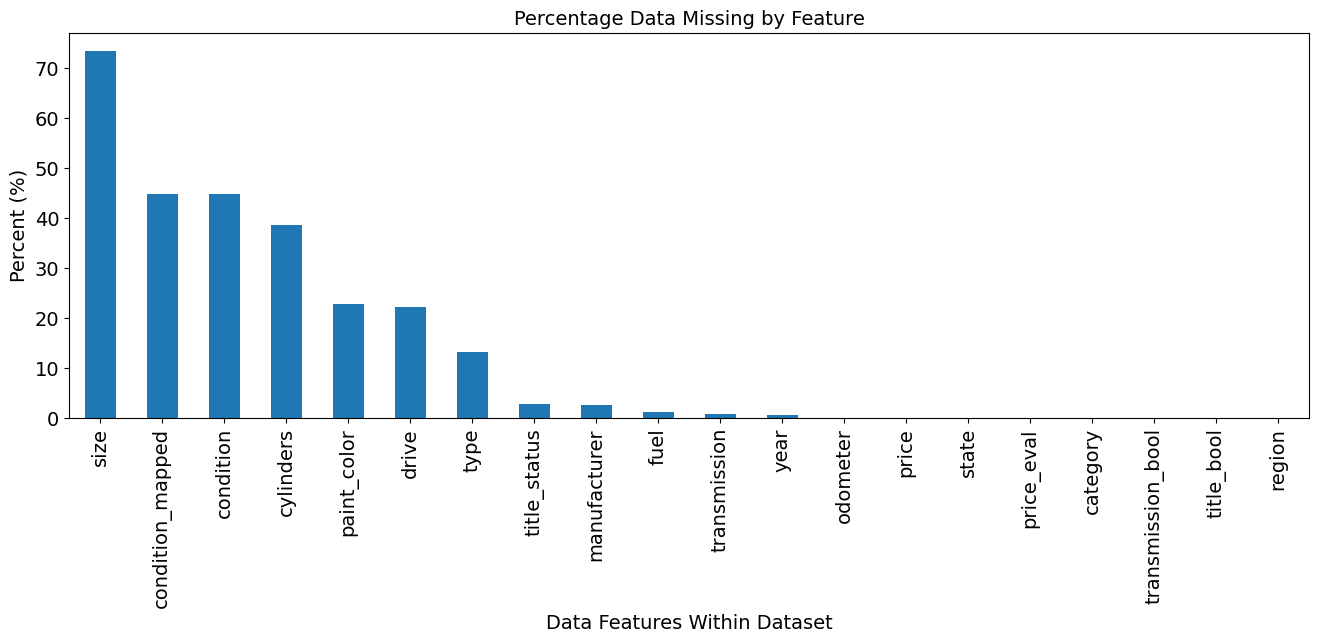

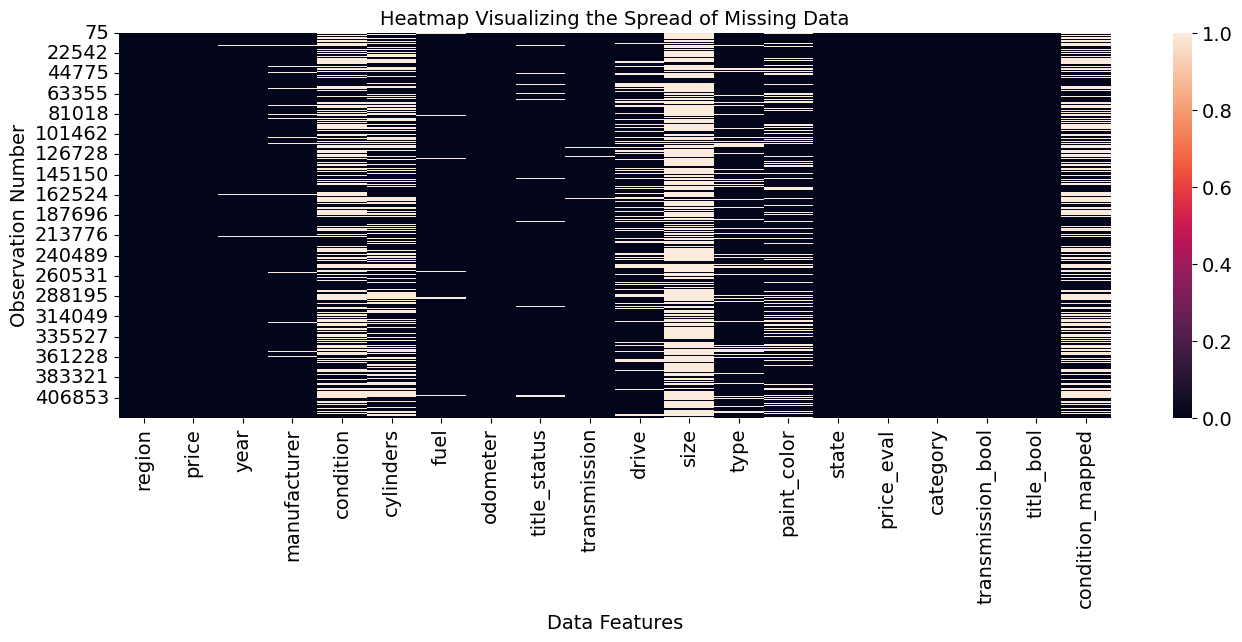

In [51]:
# Review current missing data view
print( f"original shape: {df.shape}\ncurrent shape: {df_dropped.shape}" )
review_missing_data( df_dropped )

#### Impute remaining missing values

In [52]:
# Address NaNs in categorical features by imputing values
columns_cat_fill = df_dropped.select_dtypes(include=["object"]).columns.tolist()

# The Imputers were not working out, so a custom approach to replace each category NaN with it's most_frequent
# Noting this reinforces a bias towards most frequent value, uncertain of a better approach at this time.
for col in columns_cat_fill:
    # get most frequent in that column
    vals = df_dropped[col].value_counts().sort_values(ascending=False).reset_index()
    most_frequent_value = vals.iloc[0,0]
    df_dropped[col] = df_dropped[col].fillna( most_frequent_value )

df_dropped.isna().sum().sort_values(ascending=False)

year                 530
region                 0
size                   0
title_bool             0
transmission_bool      0
category               0
price_eval             0
state                  0
paint_color            0
type                   0
drive                  0
price                  0
transmission           0
title_status           0
odometer               0
fuel                   0
cylinders              0
condition              0
manufacturer           0
condition_mapped       0
dtype: int64

In [53]:
# Address NaNs in numerical features by imputing values
columns_num_fill = df_dropped.select_dtypes(exclude=["object"]).columns.tolist()

# Noting this reinforces a bias towards most frequent value, uncertain of a better approach at this time.
for col in columns_num_fill:
    # get central tendency (test mean, median) in that column
    avg = df_dropped[col].median()
    df_dropped[col] = df_dropped[col].fillna( avg )

df_dropped.isna().sum().sort_values(ascending=False)

region               0
price                0
title_bool           0
transmission_bool    0
category             0
price_eval           0
state                0
paint_color          0
type                 0
size                 0
drive                0
transmission         0
title_status         0
odometer             0
fuel                 0
cylinders            0
condition            0
manufacturer         0
year                 0
condition_mapped     0
dtype: int64

In [54]:
print( f"\n\nOriginal Dataset Shape: {original_shape}" ) 
print( f"Cleaned Dataset Shape: {df_dropped.shape}" )
print( f"Percentage of Original Data Preserved: {round(df_dropped.shape[0] / original_shape[0] * 100, 1)}%\n\n" )

df_dropped.head()



Original Dataset Shape: (426880, 18)
Cleaned Dataset Shape: (99225, 20)
Percentage of Original Data Preserved: 23.2%




,region,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price_eval,category,transmission_bool,title_bool,condition_mapped
75,auburn,18590,2018.0000,honda,good,6 cylinders,gas,28942.0000,clean,other,fwd,full-size,sedan,white,al,valid,contemporary,not automatic,clean,good
77,auburn,21590,2018.0000,honda,good,6 cylinders,gas,7885.0000,clean,other,fwd,full-size,sedan,white,al,valid,contemporary,not automatic,clean,good
100,auburn,16590,2015.0000,hyundai,good,6 cylinders,gas,26655.0000,clean,other,fwd,full-size,sedan,white,al,valid,contemporary,not automatic,clean,good
111,auburn,28590,2018.0000,gmc,good,6 cylinders,gas,20736.0000,clean,other,fwd,full-size,SUV,white,al,valid,contemporary,not automatic,clean,good
114,auburn,20590,2017.0000,lincoln,good,6 cylinders,gas,36436.0000,clean,other,fwd,full-size,sedan,white,al,valid,contemporary,not automatic,clean,good


## Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

---
### Models to test
* LinearRegression
* Ridge
* Lasso
---

### Create Train/Test datasets
* Training and Test/Validation sets will be created from the entire dataset to establish model scoring/accuracy. 
* The features used to sanitize and engineer new features will be dropped.

In [55]:
# Copy a cleaned dataframe now that preparation is complete
df_cleaned = df_dropped.copy()

# Update the numerical values for proper dtype casting
df_cleaned = df_cleaned.astype({
    #'age': 'int32',
    'odometer': 'int32',
    'year': 'int32'
})

# Review info() before modeling begins
display( df_cleaned.info())
df_cleaned.describe([0.01])

<class 'pandas.core.frame.DataFrame'>
Index: 99225 entries, 75 to 426879
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   region             99225 non-null  object
 1   price              99225 non-null  int64 
 2   year               99225 non-null  int32 
 3   manufacturer       99225 non-null  object
 4   condition          99225 non-null  object
 5   cylinders          99225 non-null  object
 6   fuel               99225 non-null  object
 7   odometer           99225 non-null  int32 
 8   title_status       99225 non-null  object
 9   transmission       99225 non-null  object
 10  drive              99225 non-null  object
 11  size               99225 non-null  object
 12  type               99225 non-null  object
 13  paint_color        99225 non-null  object
 14  state              99225 non-null  object
 15  price_eval         99225 non-null  object
 16  category           99225 non-null  object
 

None

,price,year,odometer
count,99225.0000,99225.0000,99225.0000
mean,19016.8097,2012.3838,93901.4072
std,13648.9120,6.7085,65205.6416
min,500.0000,1905.0000,1001.0000
1%,1200.0000,1988.0000,3902.7200
50%,15888.0000,2014.0000,89540.0000
max,100000.0000,2022.0000,2711913.0000


,year,manufacturer,cylinders,fuel,odometer,drive,size,type,paint_color,state,category,transmission_bool,title_bool,condition_mapped
75,2018,honda,6 cylinders,gas,28942,fwd,full-size,sedan,white,al,contemporary,not automatic,clean,good
77,2018,honda,6 cylinders,gas,7885,fwd,full-size,sedan,white,al,contemporary,not automatic,clean,good
100,2015,hyundai,6 cylinders,gas,26655,fwd,full-size,sedan,white,al,contemporary,not automatic,clean,good
111,2018,gmc,6 cylinders,gas,20736,fwd,full-size,SUV,white,al,contemporary,not automatic,clean,good
114,2017,lincoln,6 cylinders,gas,36436,fwd,full-size,sedan,white,al,contemporary,not automatic,clean,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,2019,nissan,6 cylinders,gas,32226,fwd,full-size,sedan,white,wy,contemporary,not automatic,clean,good
426876,2020,volvo,6 cylinders,gas,12029,fwd,full-size,sedan,red,wy,contemporary,not automatic,clean,good
426877,2020,cadillac,6 cylinders,diesel,4174,4wd,full-size,hatchback,white,wy,contemporary,not automatic,clean,good
426878,2018,lexus,6 cylinders,gas,30112,fwd,full-size,sedan,silver,wy,contemporary,not automatic,clean,good


(<Axes: >, None, 22)

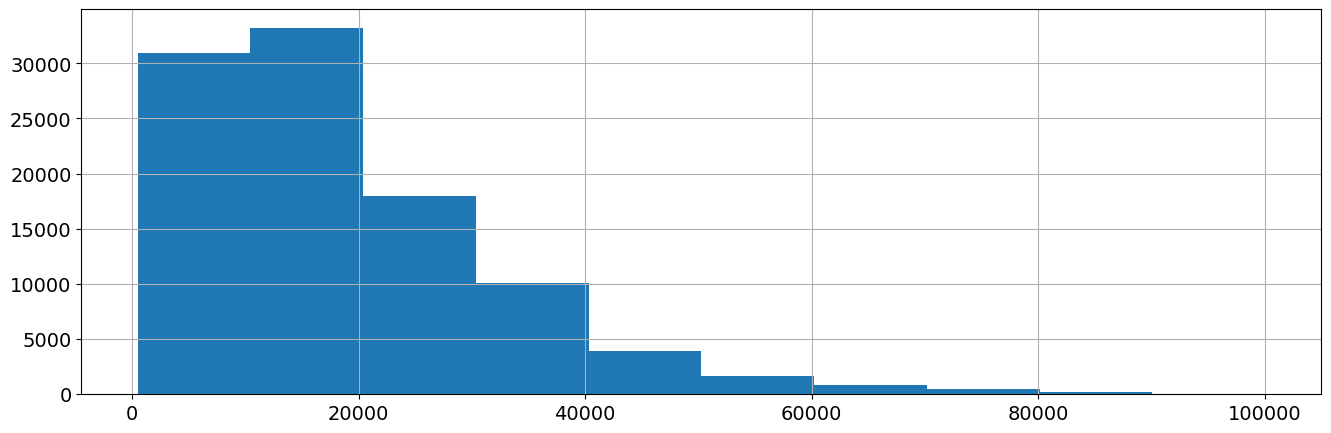

In [56]:
# Segment Variable and Target sets
#X = df_cleaned.drop(['price', 'year', 'transmission', 'title_status', 'condition', 'price_eval', 'state', 'region'], axis=1)
X = df_cleaned.drop(['price', 'transmission', 'title_status', 'condition', 'price_eval', 'region'], axis=1)
y = df_cleaned['price'] 

# Using the logorithm of `price` as it demonstrates a more normal distribution, transform within the model pipeline
y.hist(), display(X), X.duplicated().sum()

In [57]:
# Create lists of numerical and categorical features
# -- Consider: `condition` for Ordinal Encoding based on it's "scale" value set instead of binarizing it, 
#               though value of "NaN" seems prohibitive.

clean_cols_num = X.select_dtypes(exclude=['object']).columns.tolist()
clean_cols_cat = X.select_dtypes(include=['object']).columns.tolist()
# clean_cols_num, clean_cols_cat, X.isna().sum()

In [58]:
# splitting at 70/30 in this case
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train.shape , X_test.shape, y_train.shape, y_test.shape, display( X_train.info() )

<class 'pandas.core.frame.DataFrame'>
Index: 69457 entries, 210416 to 64034
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   year               69457 non-null  int32 
 1   manufacturer       69457 non-null  object
 2   cylinders          69457 non-null  object
 3   fuel               69457 non-null  object
 4   odometer           69457 non-null  int32 
 5   drive              69457 non-null  object
 6   size               69457 non-null  object
 7   type               69457 non-null  object
 8   paint_color        69457 non-null  object
 9   state              69457 non-null  object
 10  category           69457 non-null  object
 11  transmission_bool  69457 non-null  object
 12  title_bool         69457 non-null  object
 13  condition_mapped   69457 non-null  object
dtypes: int32(2), object(12)
memory usage: 7.4+ MB


None

((69457, 14), (29768, 14), (69457,), (29768,), None)

### Scale and Transform Features
Use OneHot-Encoding to transform the following categorical features into new binary/numerical features:
* `transmission_bool`
* `title_bool`
* `paint_color`
* `type`
* `drive`
* `fuel`
* `condition_mapped`
* `manufacturer`
* `category`
* `state`
* `cylinders`
* `size`

Use Polynomial transformation (`degree=3`) and Scale for numerical features
* `odometer`
* `year`


In [59]:
# Design the Model, using:
# - Column transformers
# - Standardization

# Setup column transformations; ALL tested models will use these transformations:

poly_scaler_pipeline = Pipeline ([
    ( 'pf', PolynomialFeatures( include_bias=False )),
    ( 'scale', StandardScaler() )
])

col_transformer = ColumnTransformer(transformers=(
    ( 'poly', poly_scaler_pipeline, clean_cols_num ),
    ( 'ohe', OneHotEncoder( handle_unknown='ignore', sparse_output=False, drop='if_binary' ), clean_cols_cat )
))

# GridSearchCV params that are shared between models
gs_degrees = [ 1, 2, 3 ]
gs_alphas = np.logspace( -2, 3, 15) # np.linspace(0.1, 100, 50) # or try: 
gs_fit_intercept = [ True, False ]
gs_cv = 3
gs_verbose = 0

### Setup Linear Regression Model
* Create a pipeline that transforms and scales the data, and uses Linear Regression model as the estimator
* Use GridSearch to optimize the `degree` hyperparameter for the polynomial tranformation

In [60]:
# Setup the pipeline for the estimator (Linear Regression)
lr_pipe = Pipeline ([
    ( 'transform', col_transformer ),
    ( 'reg', TransformedTargetRegressor(
            regressor=LinearRegression(),
            func=np.log1p,  # Logarithmic transformation
            inverse_func=np.expm1  # Inverse transformation
    ))
])

lr_pipe

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=(('poly',
                                                  Pipeline(steps=[('pf',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['manufacturer', 'cylinders',
                                                   'fuel', 'drive', 'size',
                                                   'type', 'paint_color',
                                                   'state', 'category',
                                                   'transmission_bool',
                                                   'title_bool',
                                                   'condition_mapped'])))),
                ('reg',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=LinearRegression()))])

In [61]:
# GridSearch setup for hyperparameter optimization to identify best estimator
lr_params = {
    'transform__poly__pf__degree': gs_degrees,
    'reg__regressor__fit_intercept': gs_fit_intercept
}

lr_grid = GridSearchCV (
    estimator = lr_pipe,
    param_grid = lr_params,
    scoring = 'neg_mean_squared_error',
    cv=gs_cv, 
    verbose = gs_verbose, 
    n_jobs = -1
)
lr_grid

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=(('poly',
                                                                         Pipeline(steps=[('pf',
                                                                                          PolynomialFeatures(include_bias=False)),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['year',
                                                                          'odometer']),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['manufacturer',
                                                                          'cylinders',
                                                                          'fuel',
                                                                          'drive',
                                                                          'size',
                                                                          'type',
                                                                          'paint_color',
                                                                          'state',
                                                                          'category',
                                                                          'transmission_bool',
                                                                          'title_bool',
                                                                          'condition_mapped'])))),
                                       ('reg',
                                        TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                                   inverse_func=<ufunc 'expm1'>,
                                                                   regressor=LinearRegression()))]),
             n_jobs=-1,
             param_grid={'reg__regressor__fit_intercept': [True, False],
                         'transform__poly__pf__degree': [1, 2, 3]},
             scoring='neg_mean_squared_error')

In [62]:
# fit the grid model
lr_grid.fit ( X_train, y_train )

# access the best model returned from the grid search
lr_best_model = lr_grid.best_estimator_
lr_best_model

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=(('poly',
                                                  Pipeline(steps=[('pf',
                                                                   PolynomialFeatures(degree=1,
                                                                                      include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['manufacturer', 'cylinders',
                                                   'fuel', 'drive', 'size',
                                                   'type', 'paint_color',
                                                   'state', 'category',
                                                   'transmission_bool',
                                                   'title_bool',
                                                   'condition_mapped'])))),
                ('reg',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=LinearRegression(fit_intercept=False)))])

### Setup Ridge Regularization Model
* Create a pipeline that transforms and scales the data, and uses Ridge Regularization model as the estimator
* Use GridSearch to optimize `degree` and `alpha` hyperparameters for the polynomial tranformation and model, respectively

In [63]:
# Setup the pipeline for the estimator (Ridge)
ridge_pipe = Pipeline ([
    ( 'transform', col_transformer ),
    ( 'reg', TransformedTargetRegressor(
            regressor=Ridge(),
            func=np.log1p,  # Logarithmic transformation
            inverse_func=np.expm1  # Inverse transformation
    ))
])

ridge_pipe

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=(('poly',
                                                  Pipeline(steps=[('pf',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['manufacturer', 'cylinders',
                                                   'fuel', 'drive', 'size',
                                                   'type', 'paint_color',
                                                   'state', 'category',
                                                   'transmission_bool',
                                                   'title_bool',
                                                   'condition_mapped'])))),
                ('reg',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=Ridge()))])

In [64]:
# GridSearch setup for hyperparameter optimization to identify best estimator
ridge_params = {
    'reg__regressor__alpha': gs_alphas,
    'transform__poly__pf__degree': gs_degrees
}

ridge_grid = GridSearchCV (
    estimator = ridge_pipe,
    param_grid = ridge_params,
    scoring = 'neg_mean_squared_error',
    cv=gs_cv, 
    verbose = gs_verbose, 
    n_jobs = -1 
)
ridge_grid

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=(('poly',
                                                                         Pipeline(steps=[('pf',
                                                                                          PolynomialFeatures(include_bias=False)),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['year',
                                                                          'odometer']),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['manufacturer',
                                                                          'cylinders',
                                                                          'fuel',
                                                                          'drive',
                                                                          'size',
                                                                          'type',
                                                                          '...
             n_jobs=-1,
             param_grid={'reg__regressor__alpha': array([1.00000000e-02, 2.27584593e-02, 5.17947468e-02, 1.17876863e-01,
       2.68269580e-01, 6.10540230e-01, 1.38949549e+00, 3.16227766e+00,
       7.19685673e+00, 1.63789371e+01, 3.72759372e+01, 8.48342898e+01,
       1.93069773e+02, 4.39397056e+02, 1.00000000e+03]),
                         'transform__poly__pf__degree': [1, 2, 3]},
             scoring='neg_mean_squared_error')

In [65]:
# fit the grid model
ridge_grid.fit ( X_train, y_train );

# access the best model returned from the grid search
ridge_best_model = ridge_grid.best_estimator_
ridge_best_model

/Users/ameet/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=(('poly',
                                                  Pipeline(steps=[('pf',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['manufacturer', 'cylinders',
                                                   'fuel', 'drive', 'size',
                                                   'type', 'paint_color',
                                                   'state', 'category',
                                                   'transmission_bool',
                                                   'title_bool',
                                                   'condition_mapped'])))),
                ('reg',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=Ridge(alpha=0.2682695795279726)))])

In [66]:
#ridge_best_model.named_steps

### Setup Lasso Regularization Model
* Create a pipeline that transforms and scales the data, and uses Lasso Regularization model as the estimator
* Use GridSearch to optimize `degree` and `alpha` hyperparameters for the polynomial tranformation and model, respectively

In [67]:
# Setup the pipeline for the estimator (Lasso)
lasso_pipe = Pipeline ([
    ( 'transform', col_transformer ),
    ( 'reg', TransformedTargetRegressor(
            regressor=Lasso( alpha = 1 ),
            func=np.log1p,  # Logarithmic transformation
            inverse_func=np.expm1  # Inverse transformation
    ))
])

lasso_pipe

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=(('poly',
                                                  Pipeline(steps=[('pf',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['manufacturer', 'cylinders',
                                                   'fuel', 'drive', 'size',
                                                   'type', 'paint_color',
                                                   'state', 'category',
                                                   'transmission_bool',
                                                   'title_bool',
                                                   'condition_mapped'])))),
                ('reg',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=Lasso(alpha=1)))])

In [68]:
# GridSearch setup for hyperparameter optimization to identify best estimator
lasso_params = {
    'reg__regressor__alpha': gs_alphas,
    'transform__poly__pf__degree': gs_degrees
}

lasso_grid = GridSearchCV (
    estimator = lasso_pipe,
    param_grid = lasso_params,
    scoring = 'neg_mean_squared_error',
    cv=gs_cv, 
    verbose = gs_verbose, 
    n_jobs = -1
)
lasso_grid


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=(('poly',
                                                                         Pipeline(steps=[('pf',
                                                                                          PolynomialFeatures(include_bias=False)),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['year',
                                                                          'odometer']),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['manufacturer',
                                                                          'cylinders',
                                                                          'fuel',
                                                                          'drive',
                                                                          'size',
                                                                          'type',
                                                                          '...
             n_jobs=-1,
             param_grid={'reg__regressor__alpha': array([1.00000000e-02, 2.27584593e-02, 5.17947468e-02, 1.17876863e-01,
       2.68269580e-01, 6.10540230e-01, 1.38949549e+00, 3.16227766e+00,
       7.19685673e+00, 1.63789371e+01, 3.72759372e+01, 8.48342898e+01,
       1.93069773e+02, 4.39397056e+02, 1.00000000e+03]),
                         'transform__poly__pf__degree': [1, 2, 3]},
             scoring='neg_mean_squared_error')

In [69]:
# fit the grid model
lasso_grid.fit ( X_train, y_train )


/Users/ameet/Library/Python/3.9/lib/python/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/ameet/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.916e+00, tolerance: 2.887e+00
  model = cd_fast.enet_coordinate_descent(
/Users/ameet/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.463e+00, tolerance: 2.887e+00
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transform',
                                        ColumnTransformer(transformers=(('poly',
                                                                         Pipeline(steps=[('pf',
                                                                                          PolynomialFeatures(include_bias=False)),
                                                                                         ('scale',
                                                                                          StandardScaler())]),
                                                                         ['year',
                                                                          'odometer']),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['manufacturer',
                                                                          'cylinders',
                                                                          'fuel',
                                                                          'drive',
                                                                          'size',
                                                                          'type',
                                                                          '...
             n_jobs=-1,
             param_grid={'reg__regressor__alpha': array([1.00000000e-02, 2.27584593e-02, 5.17947468e-02, 1.17876863e-01,
       2.68269580e-01, 6.10540230e-01, 1.38949549e+00, 3.16227766e+00,
       7.19685673e+00, 1.63789371e+01, 3.72759372e+01, 8.48342898e+01,
       1.93069773e+02, 4.39397056e+02, 1.00000000e+03]),
                         'transform__poly__pf__degree': [1, 2, 3]},
             scoring='neg_mean_squared_error')

In [70]:
# access the best model returned from the grid search
lasso_best_model = lasso_grid.best_estimator_
lasso_best_model

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=(('poly',
                                                  Pipeline(steps=[('pf',
                                                                   PolynomialFeatures(degree=1,
                                                                                      include_bias=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['year', 'odometer']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['manufacturer', 'cylinders',
                                                   'fuel', 'drive', 'size',
                                                   'type', 'paint_color',
                                                   'state', 'category',
                                                   'transmission_bool',
                                                   'title_bool',
                                                   'condition_mapped'])))),
                ('reg',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=Lasso(alpha=0.01)))])

In [71]:
# lasso_best_model.named_steps

## Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [72]:
# Setup dataframes to aggregate model comparison information
error_df = pd.DataFrame( columns=["Model", "Best Parameters", "RMSE Train", "RMSE Test", "Score Train", "Score Test"] )


---
### Collate Evaluation Metrics From the Best Estimator for Each Tested Model:
* Best hyperparameters 
* MSE errors for both Train and Test datasets
* Best model score
---
#### Linear Regression

In [73]:
lr_grid.best_params_

{'reg__regressor__fit_intercept': False, 'transform__poly__pf__degree': 1}

In [74]:
# calculate MSEs for train and test models from the best returned model, using the best parameters to transform the training and test sets

# Setup the pipeline to transform the features, using the best parameters from GS
lr_pipeline = Pipeline ([
    ( 'pf', PolynomialFeatures( degree=lr_grid.best_params_['transform__poly__pf__degree'], include_bias=False )),
    ( 'scale', StandardScaler() )
])

lr_transformer = ColumnTransformer(transformers=(
    ( 'poly', lr_pipeline, clean_cols_num ),
    ( 'ohe', OneHotEncoder( handle_unknown='ignore', sparse_output=False, drop='if_binary' ), clean_cols_cat )
))

# Fit and transform training and test values to map against predicted
pred_x_train_lr = lr_transformer.fit_transform( X_train )
pred_x_test_lr = lr_transformer.transform( X_test )

y_train_preds = lr_best_model.named_steps["reg"].predict ( pred_x_train_lr )
y_test_preds = lr_best_model.named_steps["reg"].predict ( pred_x_test_lr )

# Evaluate loss and scoring
lr_mse_train = np.sqrt( mean_squared_error ( y_train_preds, y_train ))
lr_mse_test = np.sqrt( mean_squared_error ( y_test_preds , y_test ))
lr_score_train = lr_best_model.named_steps["reg"].score ( pred_x_train_lr, y_train )
lr_score_test = lr_best_model.named_steps["reg"].score ( pred_x_test_lr, y_test )
lr_hyperparameters = f"Degree: {lr_grid.best_params_['transform__poly__pf__degree']:.3f}, Fit Intercept: {lr_grid.best_params_['reg__regressor__fit_intercept']}"

# Retain summary information for comparision
print( helper_print_heading( 'Model: Linear Regression' ))
print( f"Best Degree: {lr_grid.best_params_['transform__poly__pf__degree']:.3f}" )
print( f"Fit Intercept: {lr_grid.best_params_['reg__regressor__fit_intercept']}" )
print( f"Training RMSE: {lr_mse_train:.3f}" )
print( f"Test RMSE: {lr_mse_test:.3f}" )
print( f"Training Score: {lr_score_train:.3f}" )
print( f"Test Score: {lr_score_test:.3f}" )

error_df.loc[len(error_df.index)] = [ 'Linear Regression', 
                                       lr_hyperparameters, 
                                       round(lr_mse_train, 3), 
                                       round(lr_mse_test, 3), 
                                       round(lr_score_train, 3),
                                       round(lr_score_test, 3)
             ]



/─────────────────────────────────────────────  MODEL: LINEAR REGRESSION  ─────────────────────────────────────────────/

Best Degree: 1.000
Fit Intercept: False
Training RMSE: 8078.469
Test RMSE: 8259.798
Training Score: 0.650
Test Score: 0.633


#### Ridge Regularization

In [75]:
ridge_grid.best_params_

{'reg__regressor__alpha': 0.2682695795279726, 'transform__poly__pf__degree': 3}

In [76]:
# calculate MSEs for train and test models from the best returned model, using the best parameters to transform the training and test sets

# Setup the pipeline to transform the features, using the best parameters from GS
ridge_pipeline = Pipeline ([
    ( 'pf', PolynomialFeatures( degree=ridge_grid.best_params_['transform__poly__pf__degree'], include_bias=False )),
    ( 'scale', StandardScaler() )
])

ridge_transformer = ColumnTransformer(transformers=(
    ( 'poly', ridge_pipeline, clean_cols_num ),
    ( 'ohe', OneHotEncoder( handle_unknown='ignore', sparse_output=False, drop='if_binary' ), clean_cols_cat )
))

# # Fit and transform training and test values to map against predicted
pred_x_train_ridge = ridge_transformer.fit_transform( X_train )
pred_x_test_ridge = ridge_transformer.transform( X_test )

# Evaluate loss and scoring
ridge_mse_train = np.sqrt( mean_squared_error ( ridge_best_model.named_steps["reg"].predict ( pred_x_train_ridge ), y_train ))
ridge_mse_test = np.sqrt( mean_squared_error ( ridge_best_model.named_steps["reg"].predict ( pred_x_test_ridge ), y_test ))
ridge_score_train = ridge_best_model.named_steps["reg"].score ( pred_x_train_ridge, y_train )
ridge_score_test = ridge_best_model.named_steps["reg"].score ( pred_x_test_ridge, y_test )
ridge_hyperparameters = f"Degree: {ridge_grid.best_params_['transform__poly__pf__degree']:.3f}, Alpha: {ridge_grid.best_params_['reg__regressor__alpha']:.3f}"

# Retain summary information for comparision
print( helper_print_heading( 'Model: Ridge Regularization' ))
print( f"Best Degree: {ridge_grid.best_params_['transform__poly__pf__degree']:.3f}" )
print( f"Best Alpha: {ridge_grid.best_params_['reg__regressor__alpha']:.3f}" )
print( f"Training RMSE: {ridge_mse_train:.3f}" )
print( f"Test RMSE: {ridge_mse_test:.3f}" )
print( f"Training Score: {ridge_score_train:.3f}" )
print( f"Test Score: {ridge_score_test:.3f}" )

error_df.loc[len(error_df.index)] = [ 'Ridge Regularization', 
                                       ridge_hyperparameters, 
                                       round( ridge_mse_train, 3 ), 
                                       round( ridge_mse_test, 3 ),
                                       round( ridge_score_train, 3 ),
                                       round( ridge_score_test, 3 )
             ]


/───────────────────────────────────────────  MODEL: RIDGE REGULARIZATION  ───────────────────────────────────────────/

Best Degree: 3.000
Best Alpha: 0.268
Training RMSE: 7929.900
Test RMSE: 8074.284
Training Score: 0.663
Test Score: 0.650


#### Lasso Regularization

In [77]:
lasso_grid.best_params_

{'reg__regressor__alpha': 0.01, 'transform__poly__pf__degree': 1}

In [78]:
# calculate MSEs for train and test models from the best returned model, using the best parameters to transform the training and test sets

# Setup the pipeline to transform the features, using the best parameters from GS
lasso_pipeline = Pipeline ([
    ( 'pf', PolynomialFeatures( degree=lasso_grid.best_params_['transform__poly__pf__degree'], include_bias=False )),
    ( 'scale', StandardScaler() )
])

lasso_transformer = ColumnTransformer(transformers=(
    ( 'poly', lasso_pipeline, clean_cols_num ),
    ( 'ohe', OneHotEncoder( handle_unknown='ignore', sparse_output=False, drop='if_binary' ), clean_cols_cat )
))

# # Fit and transform training and test values to map against predicted
pred_x_train_lasso = lasso_transformer.fit_transform( X_train )
pred_x_test_lasso = lasso_transformer.transform( X_test )

# Evaluate loss and scoring
lasso_mse_train = np.sqrt( mean_squared_error ( lasso_best_model.named_steps["reg"].predict ( pred_x_train_lasso ), y_train ))
lasso_mse_test = np.sqrt( mean_squared_error ( lasso_best_model.named_steps["reg"].predict ( pred_x_test_lasso ), y_test ))
lasso_score_train = lasso_best_model.named_steps["reg"].score ( pred_x_train_lasso, y_train )
lasso_score_test = lasso_best_model.named_steps["reg"].score ( pred_x_test_lasso, y_test )
lasso_hyperparameters = f"Degree: {lasso_grid.best_params_['transform__poly__pf__degree']:.3f} , Alpha: {lasso_grid.best_params_['reg__regressor__alpha']:.3f}"

# Retain summary information for comparision
print( helper_print_heading( 'Model: Lasso Regularization' ))
print( f"Best Degree: {lasso_grid.best_params_['transform__poly__pf__degree']:.3f}" )
print( f"Best Alpha: {lasso_grid.best_params_['reg__regressor__alpha']:.3f}" )
print( f"Training RMSE: {lasso_mse_train:.3f}" )
print( f"Test RMSE: {lasso_mse_test:.3f}" )
print( f"Training Score: {lasso_score_train:.3f}" )
print( f"Test Score: {lasso_score_test:.3f}" )

error_df.loc[len(error_df.index)] = [ 'Lasso Regularization', 
                           lasso_hyperparameters, 
                           round(lasso_mse_train, 3), 
                           round(lasso_mse_test, 3), 
                           round( lasso_score_train, 3 ),
                            round( lasso_score_test, 3 ) 
             ]


/───────────────────────────────────────────  MODEL: LASSO REGULARIZATION  ───────────────────────────────────────────/

Best Degree: 1.000
Best Alpha: 0.010
Training RMSE: 9318.982
Test RMSE: 9397.154
Training Score: 0.534
Test Score: 0.526


### Review RMSEs and Scores

In [79]:
# Compare Error and Scoring metrics between models
print( 'Evaluation of Best-Fit Regression Models')
error_df

Evaluation of Best-Fit Regression Models


,Model,Best Parameters,RMSE Train,RMSE Test,Score Train,Score Test
0,Linear Regression,"Degree: 1.000, Fit Intercept: False",8078.4690,8259.7980,0.6500,0.6330
1,Ridge Regularization,"Degree: 3.000, Alpha: 0.268",7929.9000,8074.2840,0.6630,0.6500
2,Lasso Regularization,"Degree: 1.000 , Alpha: 0.010",9318.9820,9397.1540,0.5340,0.5260


### Compare Cross-Validation Results By Model

In [80]:
cv_lr = pd.DataFrame( lr_grid.cv_results_ ).sort_values('rank_test_score')
cv_lr


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg__regressor__fit_intercept,param_transform__poly__pf__degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,0.5788,0.0842,0.0614,0.0061,False,1,"{'reg__regressor__fit_intercept': False, 'tran...",-66831259.2977,-67906238.6496,-63636007.4569,-66124501.8014,1813532.1390,1
0,0.6454,0.0327,0.0709,0.0076,True,1,"{'reg__regressor__fit_intercept': True, 'trans...",-67120123.8425,-67857601.6717,-63405211.2458,-66127645.5867,1948453.2228,2
2,0.7524,0.0080,0.0606,0.0033,True,3,"{'reg__regressor__fit_intercept': True, 'trans...",-63205405.8029,-77063166.8992,-1249766705.6397,-463345092.7806,556112832.8344,3
5,0.5793,0.0149,0.0487,0.0009,False,3,"{'reg__regressor__fit_intercept': False, 'tran...",-63259636.2016,-73749898.5769,-1380475369.2660,-505828301.3482,618483700.3856,4
4,0.6064,0.0027,0.0555,0.0017,False,2,"{'reg__regressor__fit_intercept': False, 'tran...",-64537760.4123,-232132908312553.3438,-61709359.9132,-77377678186557.8906,109428472646176.0781,5
1,0.7268,0.0122,0.0638,0.0020,True,2,"{'reg__regressor__fit_intercept': True, 'trans...",-64543077.6061,-253158200706019.3438,-61638793.6815,-84386108962630.2031,119339890546788.5781,6


In [81]:
cv_ridge = pd.DataFrame( ridge_grid.cv_results_ ).sort_values('rank_test_score')
cv_ridge


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg__regressor__alpha,param_transform__poly__pf__degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
14,0.1742,0.0025,0.0529,0.0005,0.2683,3,"{'reg__regressor__alpha': 0.2682695795279726, ...",-63676549.1408,-64528322.2776,-63095729.6632,-63766867.0272,588330.0605,1
17,0.1779,0.0039,0.0547,0.0011,0.6105,3,"{'reg__regressor__alpha': 0.6105402296585329, ...",-63801604.6951,-64580152.2522,-63576320.4897,-63986025.8123,430060.3936,2
20,0.1754,0.0007,0.0535,0.0003,1.3895,3,"{'reg__regressor__alpha': 1.3894954943731375, ...",-64001095.1744,-65093487.1808,-63884759.5860,-64326447.3137,544454.5347,3
23,0.1736,0.0022,0.0580,0.0047,3.1623,3,"{'reg__regressor__alpha': 3.1622776601683795, ...",-64261726.3081,-65551163.0190,-63797818.1525,-64536902.4932,741775.3500,4
26,0.1877,0.0050,0.0588,0.0033,7.1969,3,"{'reg__regressor__alpha': 7.196856730011521, '...",-64560098.2079,-65914785.7464,-63610034.9713,-64694972.9752,945731.6166,5
29,0.2104,0.0152,0.0632,0.0021,16.3789,3,"{'reg__regressor__alpha': 16.378937069540648, ...",-64884506.4580,-66250376.8824,-63683981.8506,-64939621.7303,1048450.9636,6
32,0.1865,0.0023,0.0552,0.0017,37.2759,3,"{'reg__regressor__alpha': 37.27593720314942, '...",-65331345.3350,-66688149.3887,-64226452.3480,-65415315.6906,1006736.0944,7
18,0.1692,0.0028,0.0527,0.0012,1.3895,1,"{'reg__regressor__alpha': 1.3894954943731375, ...",-66449176.1736,-67679106.9249,-63503979.0367,-65877420.7117,1751780.3233,8
21,0.1682,0.0026,0.0537,0.0019,3.1623,1,"{'reg__regressor__alpha': 3.1622776601683795, ...",-66373072.0353,-67679400.2554,-63591572.4645,-65881348.2517,1704685.3515,9
15,0.1669,0.0014,0.0548,0.0010,0.6105,1,"{'reg__regressor__alpha': 0.6105402296585329, ...",-66597554.4779,-67747601.6526,-63452221.2619,-65932459.1308,1815550.7963,10


In [82]:
cv_lasso = pd.DataFrame( lasso_grid.cv_results_ ).sort_values('rank_test_score')
cv_lasso


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg__regressor__alpha,param_transform__poly__pf__degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.2176,0.0200,0.0667,0.0051,0.0100,1,"{'reg__regressor__alpha': 0.01, 'transform__po...",-85740034.6912,-87871126.7421,-87027861.5469,-86879674.3267,876302.0490,1
3,0.2739,0.0054,0.0716,0.0021,0.0228,1,{'reg__regressor__alpha': 0.022758459260747887...,-98402041.4783,-102137865.4976,-101804398.6768,-100781435.2176,1687984.1932,2
7,3.7108,1.7645,0.0721,0.0133,0.0518,2,"{'reg__regressor__alpha': 0.05179474679231213,...",-121707930.3532,-125996693.9203,-125160079.8097,-124288234.6944,1856243.2783,3
6,0.2775,0.0267,0.0764,0.0216,0.0518,1,"{'reg__regressor__alpha': 0.05179474679231213,...",-123210364.2055,-127210654.0452,-126698989.8096,-125706669.3534,1777470.9779,4
8,3.7030,1.7026,0.0775,0.0094,0.0518,3,"{'reg__regressor__alpha': 0.05179474679231213,...",-121543690.1954,-156043585.6255,-124970158.4799,-134185811.4336,15518953.8027,5
11,2.6318,1.6129,0.0765,0.0096,0.1179,3,"{'reg__regressor__alpha': 0.11787686347935872,...",-151501590.6069,-155624249.1471,-155014368.6938,-154046736.1493,1816831.1086,6
10,2.0551,1.8348,0.0647,0.0052,0.1179,2,"{'reg__regressor__alpha': 0.11787686347935872,...",-151688715.1805,-155797948.5189,-155249031.3904,-154245231.6966,1821567.0957,7
9,0.2590,0.0174,0.0595,0.0036,0.1179,1,"{'reg__regressor__alpha': 0.11787686347935872,...",-151867745.4354,-155972916.7615,-155467595.5221,-154436085.9063,1827770.4031,8
14,0.5121,0.0466,0.0655,0.0036,0.2683,3,"{'reg__regressor__alpha': 0.2682695795279726, ...",-180479284.9311,-185082155.9147,-183916947.4382,-183159462.7613,1953960.5250,9
13,0.4163,0.0067,0.0649,0.0035,0.2683,2,"{'reg__regressor__alpha': 0.2682695795279726, ...",-180662427.4477,-185255336.9899,-184100306.5122,-183339356.9833,1950724.2509,10


### Review Best Coefficients for Each Model

In [83]:
# Linear Regression coefs
coefs_lr = [lr_best_model.named_steps["reg"].regressor_.coef_]
coefs_lr_cols = lr_best_model.named_steps["transform"].get_feature_names_out()

coefs_lr_df = pd.DataFrame ( coefs_lr, columns = coefs_lr_cols ).T
coefs_lr_df.reset_index( inplace=True )
coefs_lr_df.rename(columns={"index":"features",0:"coefs"}, inplace = True)

# Format Coefficient magnitudes
coefs_lr_df["coefs"] = round( coefs_lr_df["coefs"], 2 )

# Whether positive or negative, create an absolute magnitude to evaluate all largest coefficients
coefs_lr_df["abs_coefs"] = abs( coefs_lr_df["coefs"] )
coefs_lr_df.sort_values( "abs_coefs", ascending=False, inplace=True )

# Tune Coefficient labels for readability (function in Custom Python Functions above)
coefs_lr_df["features"] = coefs_lr_df["features"].apply( sanitize_coef_labels )

# Save the coefficients to CSV for offline review
coefs_lr_df.to_csv("results/coefs_lr.csv", index=False)

display(coefs_lr_df)

,features,coefs,abs_coefs
51,fuel_electric,-6596297284854.0498,6596297284854.0498
53,fuel_hybrid,-6596297284854.0098,6596297284854.0098
52,fuel_gas,-6596297284854.0000,6596297284854.0000
54,fuel_other,-6596297284853.9297,6596297284853.9297
50,fuel_diesel,-6596297284853.4297,6596297284853.4297
...,...,...,...
44,cylinders_3 * cylinders,121336187565.2800,121336187565.2800
0,year,0.4500,0.4500
143,title_bool_not * clean,-0.2100,0.2100
1,odometer,-0.1900,0.1900


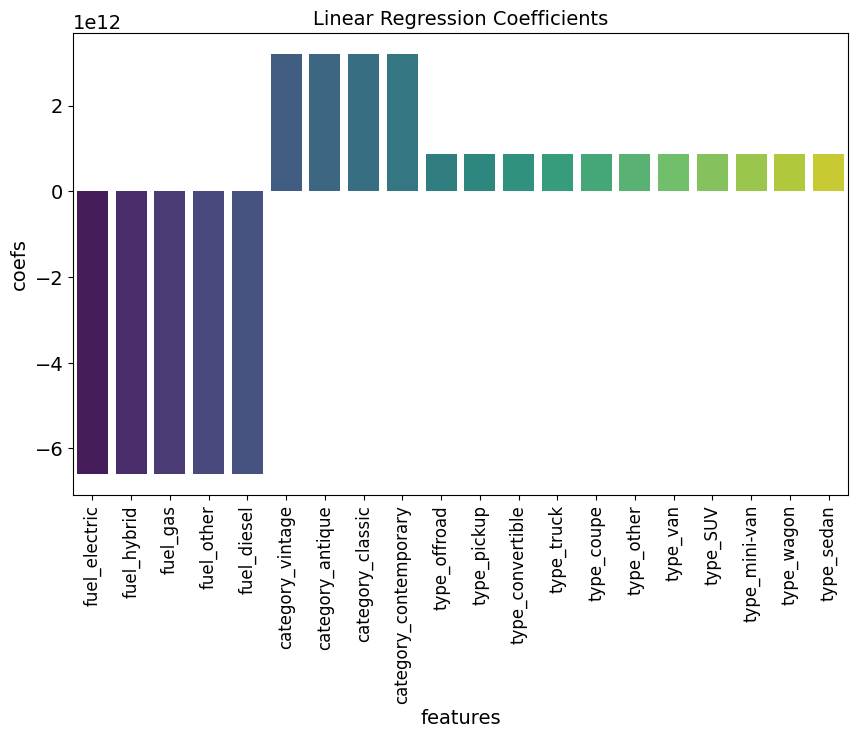

In [84]:
# Plot Linear Regression Coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='features', y='coefs', data=coefs_lr_df.head(20), palette='viridis')
plt.title('Linear Regression Coefficients')
plt.xticks(rotation=90, fontsize=12)
plt.show()

In [85]:
# Ridge Regularization coefs
coefs_ridge = [ridge_best_model.named_steps["reg"].regressor_.coef_]
coefs_ridge_cols = ridge_best_model.named_steps["transform"].get_feature_names_out()

coefs_ridge_df = pd.DataFrame ( coefs_ridge, columns = coefs_ridge_cols ).T
coefs_ridge_df.reset_index( inplace=True )
coefs_ridge_df.rename(columns={"index":"features", 0:"coefs"}, inplace = True)

# Format Coefficient magnitudes
coefs_ridge_df["coefs"] = round( coefs_ridge_df["coefs"], 2 )

# Whether positive or negative, create an absolute magnitude to evaluate all largest coefficients
coefs_ridge_df["abs_coefs"] = abs( coefs_ridge_df["coefs"] )
coefs_ridge_df.sort_values( "abs_coefs", ascending=False, inplace=True )

# Tune Coefficient labels for readability (function in Custom Python Functions above)
coefs_ridge_df["features"] = coefs_ridge_df["features"].apply( sanitize_coef_labels )


# Save the coefficients to CSV for offline review
coefs_ridge_df.to_csv("results/coefs_ridge.csv", index=False)

display(coefs_ridge_df.query("abs_coefs > 0").head(50))

print('Ridge Regression has identified 150 coefficients!')

,features,coefs,abs_coefs
5,year^3,9.8200,9.8200
0,year,-9.6000,9.6000
1,odometer,-4.9200,4.9200
6,year^2 * odometer,4.8400,4.8400
4,odometer^2,4.1800,4.1800
7,year * odometer^2,-3.8300,3.8300
145,category_antique,0.9400,0.9400
18,manufacturer_datsun,0.8800,0.8800
20,manufacturer_ferrari,0.8200,0.8200
11,manufacturer_aston-martin,0.7200,0.7200


Ridge Regression has identified 150 coefficients!


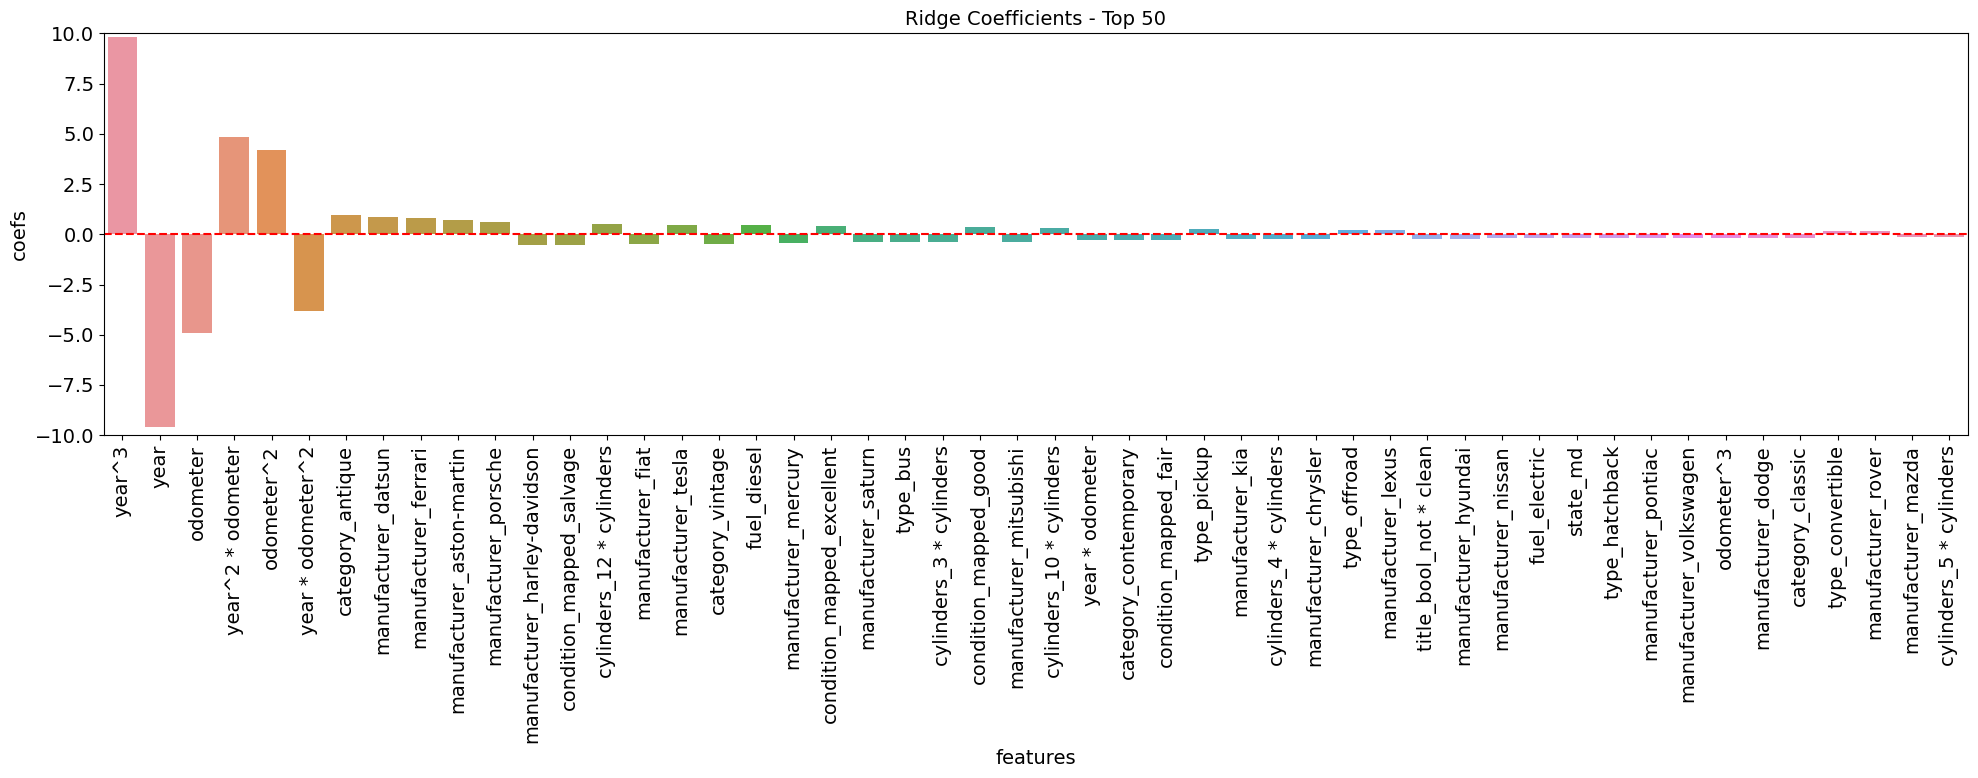

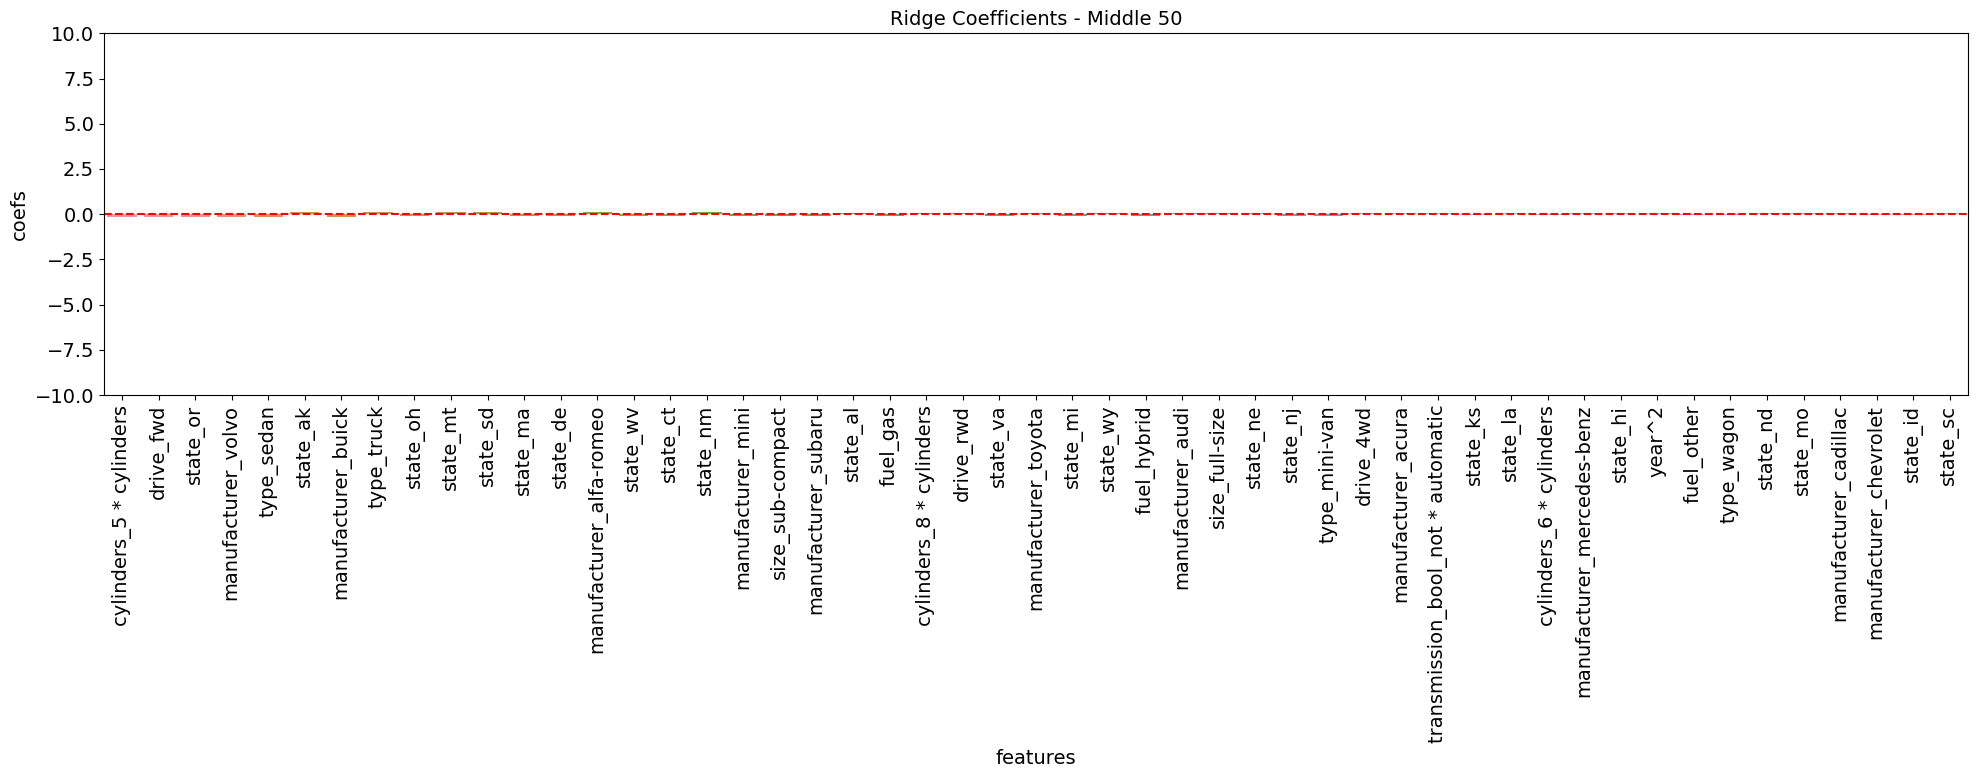

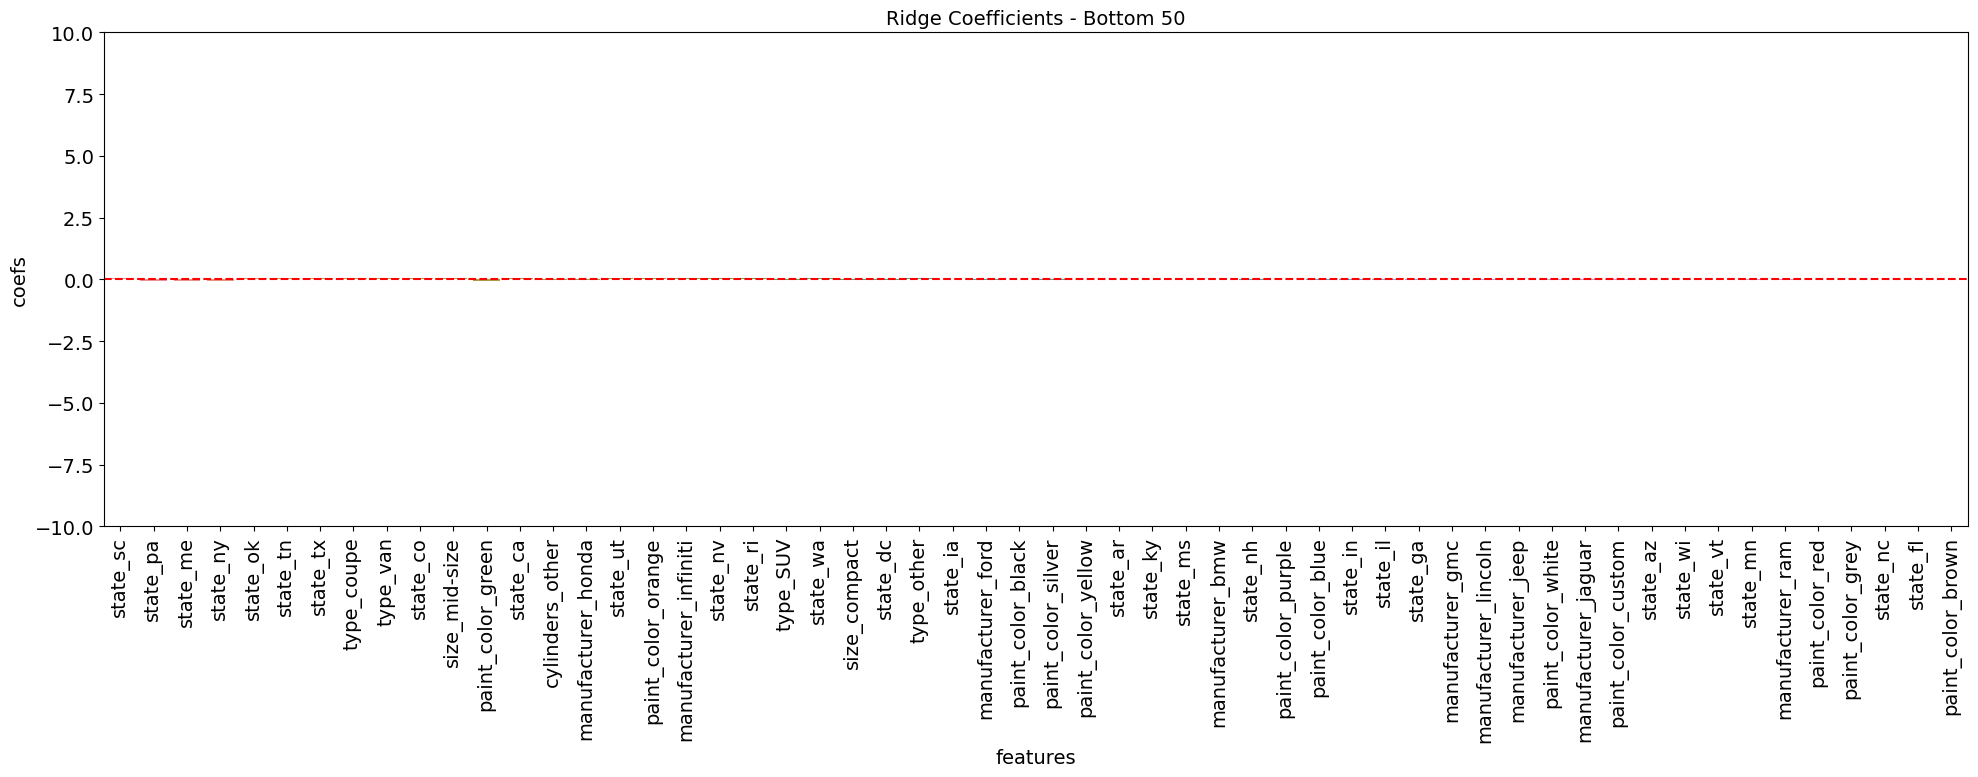

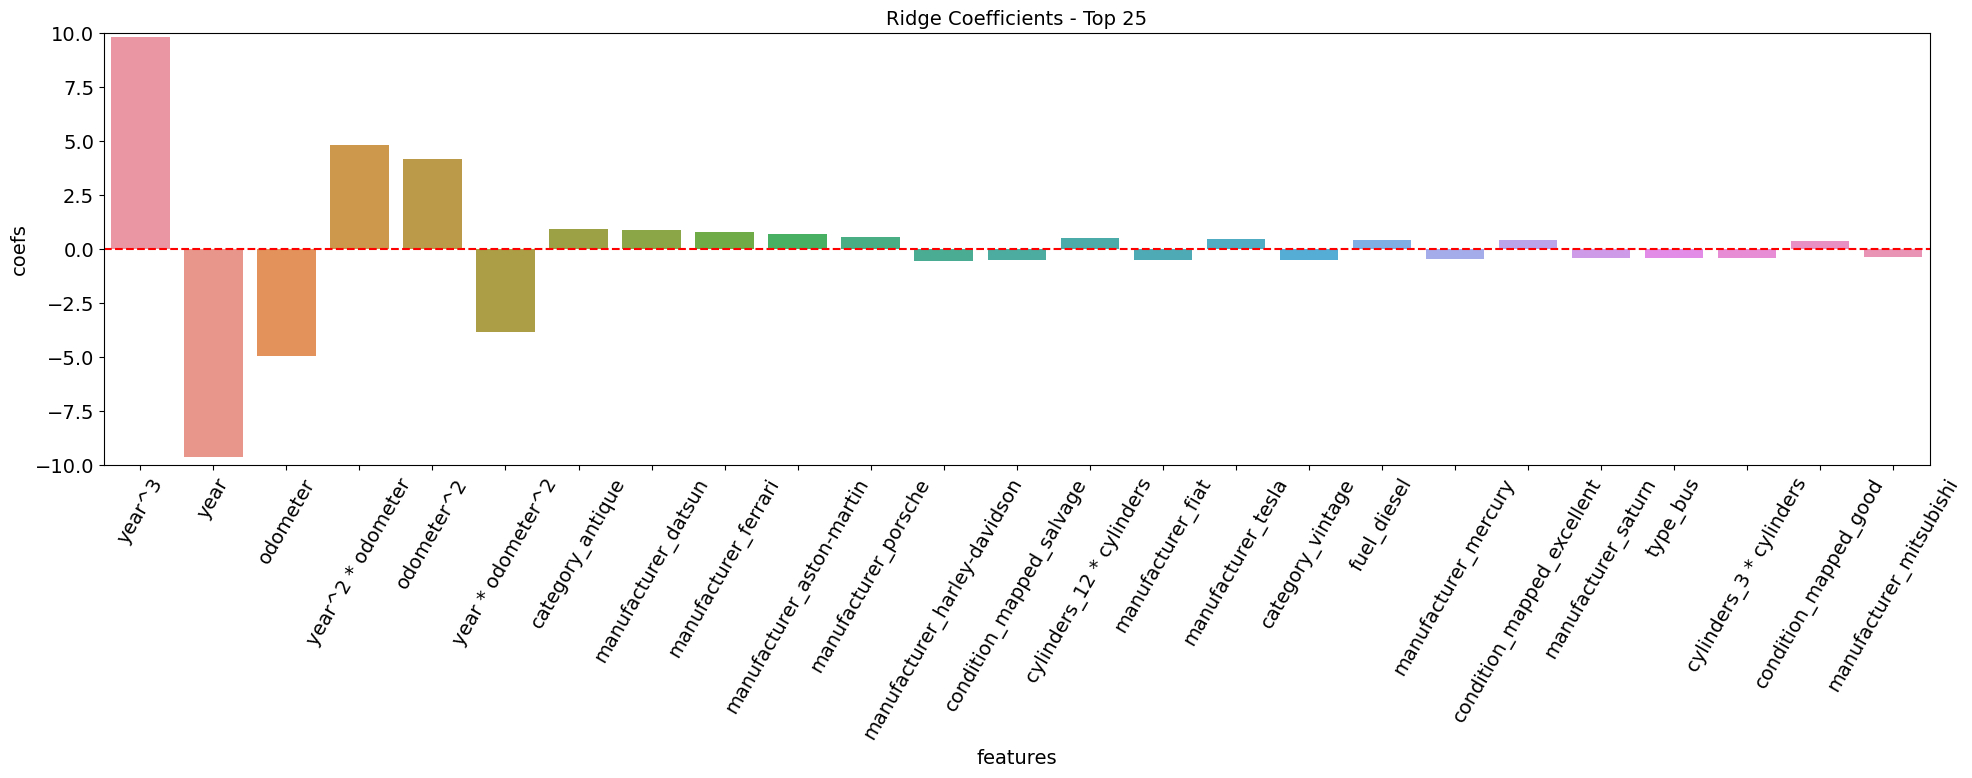

In [86]:
# Plot Ridge Coefficients

plt.figure(figsize=(20, 8))
sns.barplot(x='features', y='coefs', data=coefs_ridge_df.iloc[:50])
plt.title('Ridge Coefficients - Top 50')
plt.axhline(0, color='red', linestyle='--')
plt.xticks(rotation=90, fontsize=14)
plt.ylim(-10, 10)
plt.tight_layout()
plt.savefig('images/pa2-coefs-ridge-regression-top-50.png')
plt.show()

plt.figure(figsize=(20, 8))
sns.barplot(x='features', y='coefs', data=coefs_ridge_df.iloc[49:100])
plt.title('Ridge Coefficients - Middle 50')
plt.axhline(0, color='red', linestyle='--')
plt.xticks(rotation=90, fontsize=14)
plt.ylim(-10, 10)
plt.tight_layout()
plt.savefig('images/pa2-coefs-ridge-regression-middle-50.png')
plt.show()

plt.figure(figsize=(20, 8))
sns.barplot(x='features', y='coefs', data=coefs_ridge_df.iloc[99:])
plt.title('Ridge Coefficients - Bottom 50')
plt.axhline(0, color='red', linestyle='--')
plt.xticks(rotation=90, fontsize=14)
plt.ylim(-10, 10)
plt.tight_layout()
plt.savefig('images/pa2-coefs-ridge-regression-bottom-50.png')
plt.show()

plt.figure(figsize=(20, 8))
sns.barplot(x='features', y='coefs', data=coefs_ridge_df.iloc[:25])
plt.title('Ridge Coefficients - Top 25')
plt.axhline(0, color='red', linestyle='--')
plt.xticks(rotation=60, fontsize=14)
plt.ylim(-10, 10)
plt.tight_layout()
plt.savefig('images/pa2-coefs-ridge-regression-top-25.png')
plt.show()

In [87]:
# Lasso Regularization coefs
coefs_lasso = [lasso_best_model.named_steps["reg"].regressor_.coef_]
coefs_lasso_cols = lasso_best_model.named_steps["transform"].get_feature_names_out().tolist()

coefs_ridge_df = pd.DataFrame ( coefs_ridge, columns = coefs_ridge_cols ).T
coefs_ridge_df.reset_index( inplace=True )
coefs_ridge_df.rename(columns={"index":"features", 0:"coefs"}, inplace = True)
coefs_ridge_df["coefs"] = round( coefs_ridge_df["coefs"], 2 )
coefs_ridge_df["abs_coefs"] = abs( coefs_ridge_df["coefs"] )

coefs_ridge_df.sort_values( "abs_coefs", ascending=False, inplace=True )

coefs_lasso_df = pd.DataFrame ( coefs_lasso, columns = coefs_lasso_cols ).T
coefs_lasso_df.reset_index( inplace=True )
coefs_lasso_df.rename(columns={"index":"features", 0:"coefs"}, inplace = True)
coefs_lasso_df["coefs"] = round( coefs_lasso_df["coefs"], 2 )
coefs_lasso_df["abs_coefs"] =  abs( coefs_lasso_df["coefs"] )

coefs_lasso_df.sort_values( "abs_coefs", ascending=False, inplace=True )

# Save the coefficients to CSV for offline review
coefs_lasso_df.to_csv("results/coefs_lasso_deg2_alpha0.1.csv", index=False)

display(coefs_lasso_df.query('abs_coefs > 0'))

,features,coefs,abs_coefs
50,ohe__fuel_diesel,0.3400,0.3400
56,ohe__drive_fwd,-0.3000,0.3000
1,poly__odometer,-0.2800,0.2800
0,poly__year,0.2400,0.2400
70,ohe__type_pickup,0.2000,0.2000
45,ohe__cylinders_4 cylinders,-0.1900,0.1900
48,ohe__cylinders_8 cylinders,0.1400,0.1400
71,ohe__type_sedan,-0.0900,0.0900
52,ohe__fuel_gas,-0.0800,0.0800
72,ohe__type_truck,0.0600,0.0600


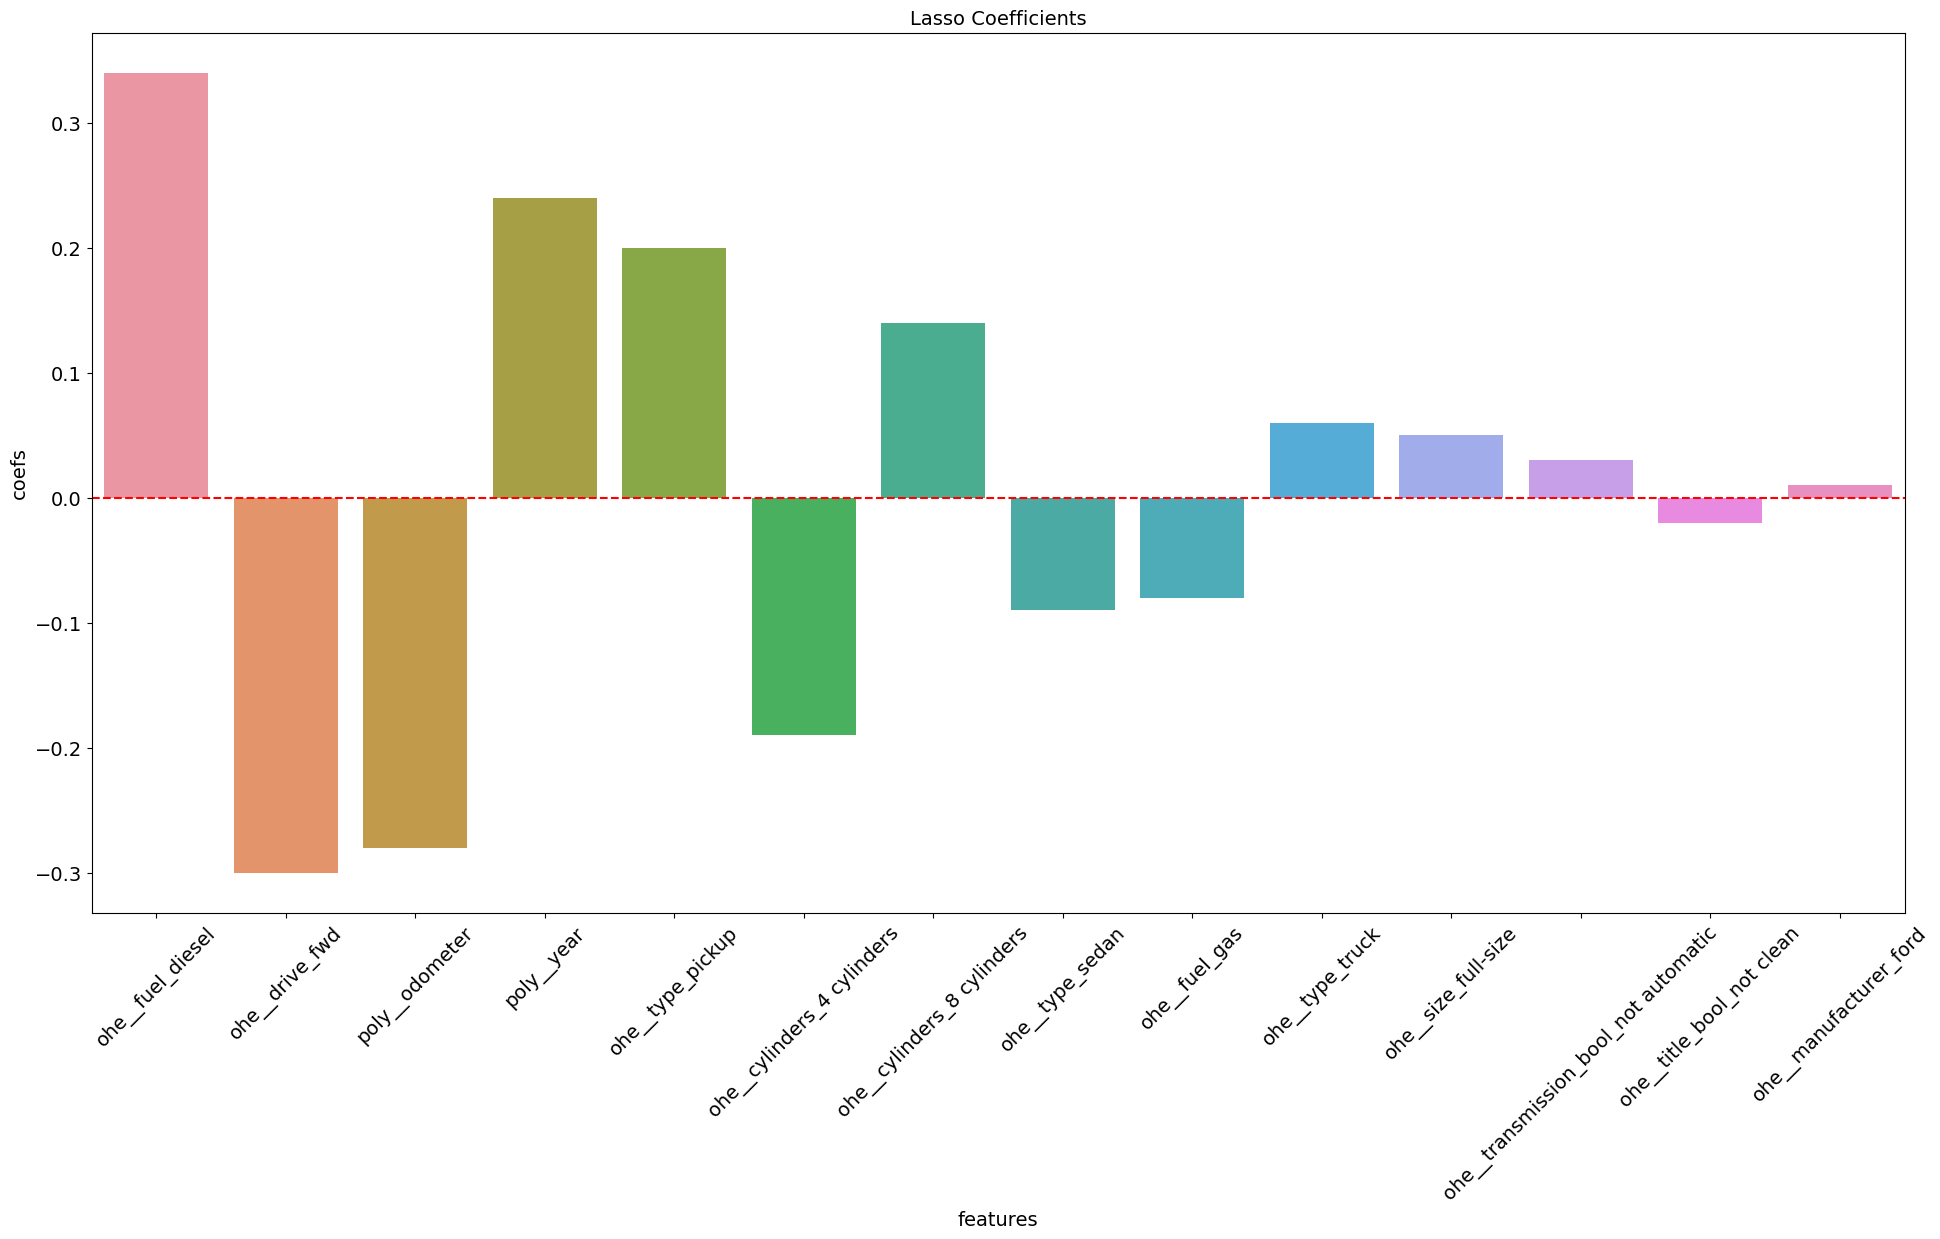

In [88]:
# Plot Lasso Coefficients

plt.figure(figsize=(20, 10))
sns.barplot(x='features', y='coefs', data=coefs_lasso_df.query('abs_coefs > 0'))
plt.title('Lasso Coefficients')
plt.axhline(0, color='red', linestyle='--')
plt.tight_layout()
plt.xticks(rotation=45, fontsize=14) 
plt.show()

## Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.